In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

%pip install torch torchvision timm scikit-learn pandas matplotlib seaborn tqdm

import os, re, math, random
from typing import Optional, Dict, List, Tuple

import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, utils as vutils
import timm
from tqdm import tqdm

# --- Paths ---
META_PATH = "/content/drive/MyDrive/IARCImageBankVIA/Cases Meta data JH.xlsx"
IMG_ROOT  = "/content/drive/MyDrive/IARCImageBankVIA"  # <- change here if your path is different

# --- Splits / training ---
TEST_FRACTION = 0.20
KFOLDS, FOLD  = 4, 0
IMAGE_SIZE    = 384
BATCH_SIZE    = 16
NUM_WORKERS   = 8
NUM_VIA_CLASSES = 3
OUTDIR        = "runs/VIA_multitask_EffB0_suffixOnly"
os.makedirs(OUTDIR, exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
set_seed(42); print('Device:', device)


Device: cpu


In [ ]:

valid_ext = (".jpg",".jpeg",".png",".tif",".tiff",".bmp")
all_imgs = []
suffix1_imgs = []

for root, _, files in os.walk(IMG_ROOT):
    for f in files:
        if not f.lower().endswith(valid_ext):
            continue
        fp = os.path.join(root, f)
        all_imgs.append(fp)
        if re.search(r"1(?=\.[^.]+$)", f, re.IGNORECASE):
            suffix1_imgs.append(fp)

print(f"Total image files found under IMG_ROOT: {len(all_imgs)}")
print(f"Image files ending in '1' before extension: {len(suffix1_imgs)}")

print("\nFirst 20 image files:")
for p in all_imgs[:20]:
    print(p)

print("\nFirst 20 suffix-1 image files:")
for p in suffix1_imgs[:20]:
    print(p)


Total image files found under IMG_ROOT: 532
Image files ending in '1' before extension: 300

First 20 image files:
/content/drive/MyDrive/IARCImageBankVIA/Case 001/AFC1.jpg
/content/drive/MyDrive/IARCImageBankVIA/Case 001/AFC0.jpg
/content/drive/MyDrive/IARCImageBankVIA/Case 002/AJL0.jpg
/content/drive/MyDrive/IARCImageBankVIA/Case 002/AJL1.jpg
/content/drive/MyDrive/IARCImageBankVIA/Case 003/AGY0.jpg
/content/drive/MyDrive/IARCImageBankVIA/Case 003/AGY1.jpg
/content/drive/MyDrive/IARCImageBankVIA/Case 004/AJE1.jpg
/content/drive/MyDrive/IARCImageBankVIA/Case 004/AJE0.jpg
/content/drive/MyDrive/IARCImageBankVIA/Case 005/AHS1.jpg
/content/drive/MyDrive/IARCImageBankVIA/Case 005/AHS0.jpg
/content/drive/MyDrive/IARCImageBankVIA/Case 007/AFE0.jpg
/content/drive/MyDrive/IARCImageBankVIA/Case 007/AFE1.jpg
/content/drive/MyDrive/IARCImageBankVIA/Case 008/AMF0.jpg
/content/drive/MyDrive/IARCImageBankVIA/Case 008/AMF1.jpg
/content/drive/MyDrive/IARCImageBankVIA/case 010/AJG1.jpg
/content/drive/

In [ ]:

normalize = transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
data_transforms_train = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.1),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=3)], p=0.1),
    transforms.ToTensor(),
    normalize,
])
data_transforms_eval = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    normalize,
])
def show_batch_grid(images_batch, title='Batch Grid'):
    grid = torchvision.utils.make_grid(images_batch, nrow=4, normalize=True, scale_each=True)
    plt.figure(figsize=(8,8)); plt.imshow(np.transpose(grid.numpy(), (1,2,0))); plt.title(title); plt.axis('off'); plt.show()


In [ ]:

ATTR_COLS = [
    "SCJ",
    "SCJ Location",
    "Acitowhite area",
    "Acitowhite area color",
    "Acitowhite area margin",
    "Acitowhite area surface",
    "Acitowhite area location",
    "Acitowhite area size",
]

def _load_meta_any(path: str) -> pd.DataFrame:
    ext = os.path.splitext(path)[1].lower()
    if ext == ".csv":  df = pd.read_csv(path)
    elif ext in (".xlsx", ".xls"): df = pd.read_excel(path)
    else: raise ValueError(f"Unsupported metadata extension: {ext}")
    return df.fillna("")

def pick(df, names):
    low = {c.lower(): c for c in df.columns}
    for nm in names:
        if nm.lower() in low: return low[nm.lower()]
    return None

def _via_to_label(v):
    s = str(v).strip().lower()
    pos = {"via+","positive","+","p","positive (via)"}
    neg = {"via-","negative","-","n","normal","negative (via)"}
    sus = {"suspicious","suspected","indeterminate","susp",
           "suspicious of cancer"}
    if s in pos or s == "2": return 2
    if s in sus or s == "1": return 1
    if s in neg or s == "0": return 0
    return None

def _safe_int_from_any(x):
    try:
        if pd.isna(x): return None
        if isinstance(x, (int, np.integer)): return int(x)
        if isinstance(x, (float, np.floating)) and not np.isnan(x): return int(round(x))
        s = str(x).strip()
        if s.isdigit(): return int(s)
        return int(float(s))
    except Exception:
        return None

def _extract_case_number_from_path(path: str) -> Optional[int]:
    patterns = [
        r"(?:\\b|_)(?:case)\\s*0*([0-9]+)\\b",
        r"(?:\\b|_)(?:patient)\\s*0*([0-9]+)\\b",
        r"(?:\\b|_)[cC]\\s*0*([0-9]+)\\b",
    ]
    for pat in patterns:
        m = re.search(pat, os.path.basename(path), flags=re.IGNORECASE)
        if not m:
            for p in os.path.normpath(path).split(os.sep):
                m = re.search(pat, p, flags=re.IGNORECASE)
                if m: break
        if m:
            try: return int(m.group(1))
            except: return None
    return None

def _stem_letters(stem: str) -> str:
    return re.sub(r"[0-9]+$", "", stem).upper()

meta_full = _load_meta_any(META_PATH)
print("Columns in metadata:", list(meta_full.columns))

attr_value_to_idx: Dict[str, Dict[str,int]] = {}
attr_idx_to_value: Dict[str, Dict[int,str]] = {}
for col in ATTR_COLS:
    if col not in meta_full.columns:
        print(f"[WARN] Attribute column '{col}' not found in metadata; will treat as all missing.")
        attr_value_to_idx[col] = {}
        attr_idx_to_value[col] = {}
        continue
    raw_vals = meta_full[col].tolist()
    canon_vals = []
    for v in raw_vals:
        s = str(v).strip()
        if s == "" or s.lower() == "nan":
            continue
        canon_vals.append(s)
    uniq = sorted(set(canon_vals))
    v2i = {v:i for i,v in enumerate(uniq)}
    i2v = {i:v for v,i in v2i.items()}
    attr_value_to_idx[col] = v2i
    attr_idx_to_value[col] = i2v
    print(f"[{col}] num_classes={len(v2i)} ->", v2i)

attr_num_classes = [len(attr_value_to_idx[c]) for c in ATTR_COLS]
print("attr_num_classes order (matches ATTR_COLS):", attr_num_classes)


Columns in metadata: ['CaseNumber', 'CaseID', 'SCJ', 'SCJ Location', 'Acitowhite area', 'Acitowhite area color', 'Acitowhite area margin', 'Acitowhite area surface', 'Acitowhite area location', 'Acitowhite area size', 'VIA', 'Eligibility for ablative treatment', 'Histology findings', 'Unnamed: 13']
[SCJ] num_classes=3 -> {'Fully visible': 0, 'Not visible': 1, 'Partially visible': 2}
[SCJ Location] num_classes=2 -> {'On ectocervix': 0, 'Partly on ectocervix and partly on endocervix': 1}
[Acitowhite area] num_classes=2 -> {'Absent': 0, 'Present': 1}
[Acitowhite area color] num_classes=2 -> {'Dense': 0, 'Thin': 1}
[Acitowhite area margin] num_classes=4 -> {'Diffuse': 0, 'Sharp and raised': 1, 'Sharp and regular': 2, 'Sharp but irregular': 3}
[Acitowhite area surface] num_classes=2 -> {'Irregular': 0, 'Smooth': 1}
[Acitowhite area location] num_classes=2 -> {'Outside TZ': 0, 'Within TZ or close to the external os (if SCJ is not visible)': 1}
[Acitowhite area size] num_classes=2 -> {'Coveri

In [ ]:
import torch

def via_sensitivity(logits, targets, pos_class=2):
    """
    logits: B x num_classes
    targets: B (long)
    pos_class: which class index to treat as "positive"
    returns: scalar tensor sensitivity = TP / (TP + FN)
    """
    preds = logits.argmax(dim=1)
    targets = targets.view(-1)

    pos_mask = (targets == pos_class)
    if pos_mask.sum() == 0:
        # no positive targets in this batch -> undefined; return NaN or 0
        return torch.tensor(float('nan'), device=logits.device)

    tp = ((preds == pos_class) & pos_mask).sum().float()
    fn = ((preds != pos_class) & pos_mask).sum().float()
    sens = tp / (tp + fn + 1e-8)
    return sens


In [ ]:

class VIAImageDataset(Dataset):
    def __init__(self, meta_path, img_root, transform=None, keep_patient_ids: Optional[set]=None, verbose=False):
        self.img_root = img_root
        self.items: List[Dict] = []
        self.keep_patient_ids = keep_patient_ids
        self.verbose = verbose

        df = _load_meta_any(meta_path)
        caseid_col  = pick(df, ["CaseID","caseid","Case Id","Case_ID"])
        caseno_col  = pick(df, ["CaseNumber","casenumber","Case Number","Case_No","CaseNo"])
        via_col     = pick(df, ["VIA","via","VIA result","VIA_result","Diagnosis"])
        if via_col is None:
            raise ValueError("Could not find a 'VIA' label column in metadata.")

        id_to_record: Dict[str, Dict] = {}
        num_to_record: Dict[int, Dict] = {}

        for _, r in df.iterrows():
            via_lab = _via_to_label(r.get(via_col, ""))
            if via_lab is None:
                continue

            attr_targets: List[int] = []
            for col in ATTR_COLS:
                if col not in df.columns:
                    attr_targets.append(-1)
                    continue
                raw = str(r.get(col, "")).strip()
                if raw == "" or raw.lower() == "nan":
                    attr_targets.append(-1)
                else:
                    if raw in attr_value_to_idx.get(col, {}):
                        attr_targets.append(attr_value_to_idx[col][raw])
                    else:
                        attr_targets.append(-1)

            rec = {"via": int(via_lab), "attrs": attr_targets}

            if caseid_col and str(r.get(caseid_col, "")).strip():
                cid = str(r[caseid_col]).strip().upper()
                id_to_record[cid] = rec

            if caseno_col and str(r.get(caseno_col, "")).strip():
                cn = _safe_int_from_any(r[caseno_col])
                if cn is not None:
                    num_to_record[cn] = rec

        valid_ext = (".jpg",".jpeg",".png",".tif",".tiff",".bmp")
        total_seen = 0; end1_seen = 0; matched = 0; no_meta = 0
        for root, _, files in os.walk(self.img_root):
            for f in files:
                total_seen += 1
                if not f.lower().endswith(valid_ext):
                    continue
                # enforce suffix '1' before extension
                if not re.search(r"1(?=\.[^.]+$)", f, re.IGNORECASE):
                    continue
                end1_seen += 1

                fp = os.path.join(root, f)
                stem, _ = os.path.splitext(os.path.basename(fp))
                letters = _stem_letters(stem)
                case_num_in_path = _extract_case_number_from_path(root)

                rec = None
                pid = None

                if letters and letters in id_to_record:
                    rec = id_to_record[letters]; pid = letters
                if rec is None and case_num_in_path is not None and case_num_in_path in num_to_record:
                    rec = num_to_record[case_num_in_path]; pid = f"{case_num_in_path:03d}"

                if rec is None:
                    no_meta += 1
                    if self.verbose and no_meta <= 10:
                        print(f"[no_meta] {fp}")
                    continue

                if self.keep_patient_ids is not None and pid not in self.keep_patient_ids:
                    continue

                self.items.append({
                    "filepath": fp,
                    "via":      rec["via"],
                    "attrs":    rec["attrs"],
                    "patient_id": pid or letters or "unknown",
                })
                matched += 1

        if self.verbose:
            print(f"[scan] total_seen={total_seen}, end1_seen={end1_seen}, matched={matched}, skipped_no_meta={no_meta}")
        self.tform = transform

    def __len__(self): return len(self.items)

    def __getitem__(self, idx):
        it = self.items[idx]
        img = Image.open(it["filepath"]).convert("RGB")
        img_t = self.tform(img) if self.tform else data_transforms_eval(img)

        via = torch.tensor(it["via"]).long()
        attrs = torch.tensor(it["attrs"]).long()   # shape [8]
        meta = {"patient_id": it["patient_id"], "path": it["filepath"]}
        return img_t, via, attrs, meta


[scan] total_seen=535, end1_seen=300, matched=300, skipped_no_meta=0
Unique patients (after VIA filtering): 300
Patients split -> train=180 | val=60 | test=60


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Train batch -> images torch.Size([16, 3, 384, 384]), via torch.Size([16]), attrs torch.Size([16, 8])


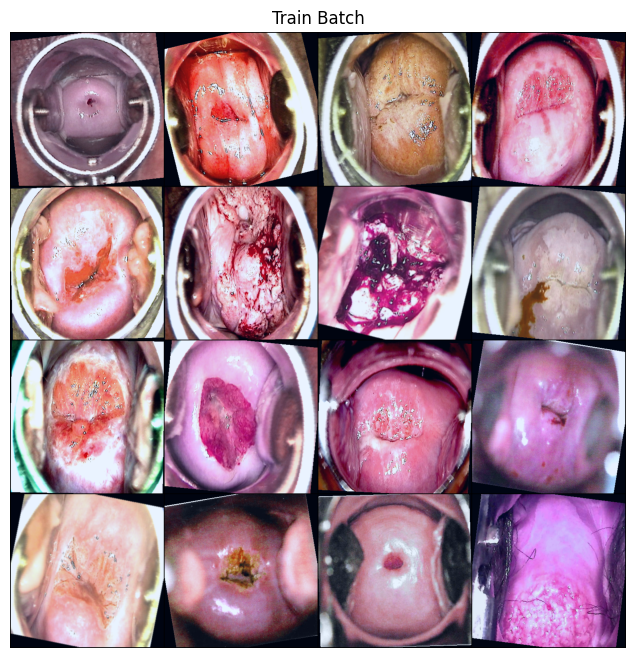

Val batch -> images torch.Size([16, 3, 384, 384]), via torch.Size([16]), attrs torch.Size([16, 8])


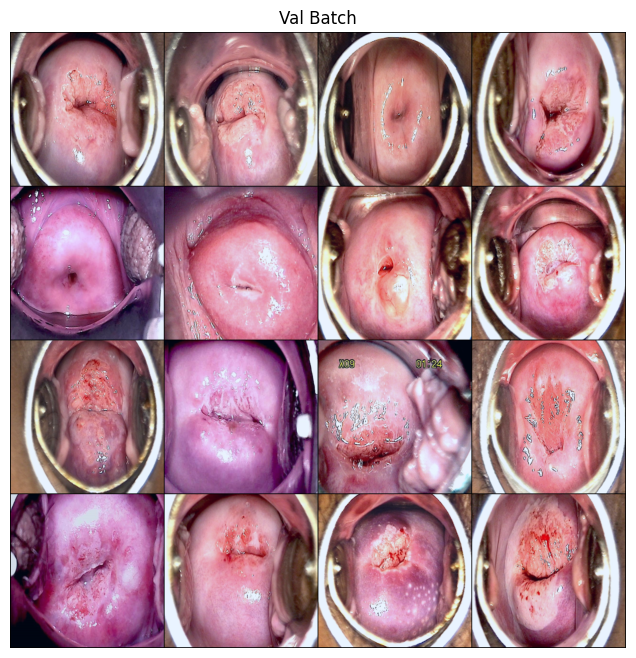

Test batch -> images torch.Size([16, 3, 384, 384]), via torch.Size([16]), attrs torch.Size([16, 8])


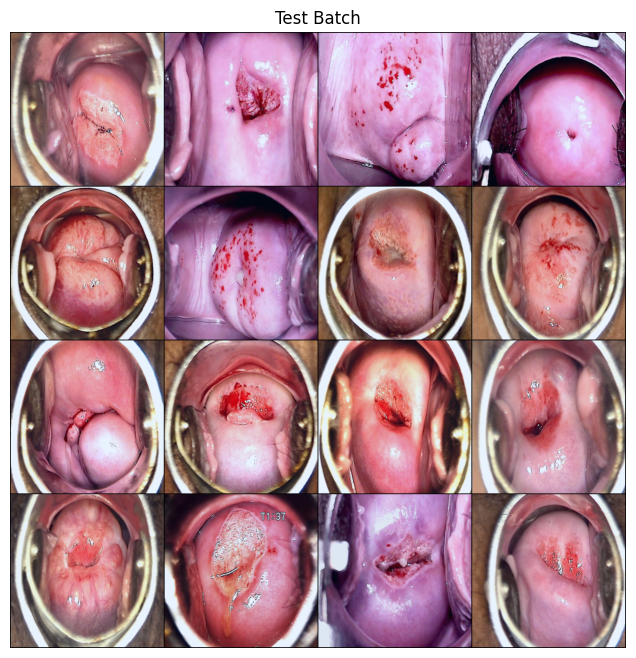

In [ ]:

_boot = VIAImageDataset(META_PATH, IMG_ROOT, transform=data_transforms_eval, keep_patient_ids=None, verbose=True)
pids = sorted({it['patient_id'] for it in _boot.items})
if len(_boot) == 0:
    print("""ERROR: Dataset has 0 items.
- Check the debug scan above:
  * If `Image files ending in '1'` is 0, then there are no suffix-1 files under IMG_ROOT.
  * If there ARE suffix-1 files but `matched=0`, then CaseID/CaseNumber are not matching metadata.
Fix IMG_ROOT or naming and rerun.
""" )
else:
    print(f"Unique patients (after VIA filtering): {len(pids)}")

    random.Random(2025).shuffle(pids)
    n_test = max(1, int(round(len(pids)*TEST_FRACTION)))
    test_pids = set(pids[:n_test])
    rest_pids = [p for p in pids if p not in test_pids]

    fold_size = max(1, math.ceil(len(rest_pids)/KFOLDS))
    val_pids = set(rest_pids[FOLD*fold_size : min((FOLD+1)*fold_size, len(rest_pids))])
    train_pids = set(p for p in rest_pids if p not in val_pids)

    print(f"Patients split -> train={len(train_pids)} | val={len(val_pids)} | test={len(test_pids)}")

    train_ds = VIAImageDataset(META_PATH, IMG_ROOT, transform=data_transforms_train, keep_patient_ids=train_pids)
    val_ds   = VIAImageDataset(META_PATH, IMG_ROOT, transform=data_transforms_eval,  keep_patient_ids=val_pids)
    test_ds  = VIAImageDataset(META_PATH, IMG_ROOT, transform=data_transforms_eval,  keep_patient_ids=test_pids)

    def make_loader(ds, shuffle):
        return DataLoader(ds, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=shuffle, pin_memory=True)

    train_loader=make_loader(train_ds, True)
    val_loader  =make_loader(val_ds,   False)
    test_loader =make_loader(test_ds,  False)

    for name, loader in [('Train',train_loader),('Val',val_loader),('Test',test_loader)]:
        xb, yb, attrs_b, meta_b = next(iter(loader))
        print(f"{name} batch -> images {xb.shape}, via {yb.shape}, attrs {attrs_b.shape}")
        show_batch_grid(xb, f"{name} Batch")


In [ ]:

class MultiTaskEfficientNet(nn.Module):
    def __init__(self, num_via_classes: int, attr_num_classes: List[int],
                 backbone_name: str = "efficientnet_b0",
                 dropout: float = 0.4,
                 pretrained: bool = True):
        super().__init__()
        assert len(attr_num_classes) == len(ATTR_COLS) == 8, "Expected 8 attribute tasks."
        self.attr_num_classes = attr_num_classes

        self.trunk = timm.create_model(backbone_name, pretrained=pretrained,
                                       features_only=True, out_indices=[-1])
        feat_ch = self.trunk.feature_info[-1]["num_chs"]
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.fc  = nn.Sequential(
            nn.Conv2d(feat_ch, 512, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.Dropout(dropout),
        )
        self.head_via = nn.Conv2d(512, num_via_classes, 1)

        (n_scj,
         n_scj_loc,
         n_aw_area,
         n_aw_color,
         n_aw_margin,
         n_aw_surface,
         n_aw_loc,
         n_aw_size) = attr_num_classes

        self.head_scj        = nn.Conv2d(512, n_scj,        1)
        self.head_scj_loc    = nn.Conv2d(512, n_scj_loc,    1)
        self.head_aw_area    = nn.Conv2d(512, n_aw_area,    1)
        self.head_aw_color   = nn.Conv2d(512, n_aw_color,   1)
        self.head_aw_margin  = nn.Conv2d(512, n_aw_margin,  1)
        self.head_aw_surface = nn.Conv2d(512, n_aw_surface, 1)
        self.head_aw_loc     = nn.Conv2d(512, n_aw_loc,     1)
        self.head_aw_size    = nn.Conv2d(512, n_aw_size,    1)

    def _head(self, conv, h):
        return conv(h).flatten(1)

    def forward(self, x):
        feats  = self.trunk(x)[0]
        pooled = self.gap(feats)
        h      = self.fc(pooled)
        out = {}
        out["via_logits"]        = self._head(self.head_via,        h)
        out["scj_logits"]        = self._head(self.head_scj,        h)
        out["scj_loc_logits"]    = self._head(self.head_scj_loc,    h)
        out["aw_area_logits"]    = self._head(self.head_aw_area,    h)
        out["aw_color_logits"]   = self._head(self.head_aw_color,   h)
        out["aw_margin_logits"]  = self._head(self.head_aw_margin,  h)
        out["aw_surface_logits"] = self._head(self.head_aw_surface, h)
        out["aw_loc_logits"]     = self._head(self.head_aw_loc,     h)
        out["aw_size_logits"]    = self._head(self.head_aw_size,    h)
        return out


In [ ]:

class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, alpha: Optional[List[float]] = None, reduction="mean"):
        super().__init__()
        self.gamma = gamma
        self.alpha = torch.tensor(alpha, dtype=torch.float32) if alpha is not None else None
        self.reduction = reduction
    def forward(self, logits, targets):
        ce = F.cross_entropy(logits, targets, reduction="none")
        pt = torch.exp(-ce)
        loss = (1 - pt) ** self.gamma * ce
        if self.alpha is not None:
            if self.alpha.device != logits.device:
                self.alpha = self.alpha.to(logits.device)
            loss = self.alpha.gather(0, targets) * loss
        return loss.mean()

def masked_ce(logits, targets):
    mask = targets >= 0
    if not mask.any():
        return None
    return F.cross_entropy(logits[mask], targets[mask])

TASK_WEIGHTS = {
    "via":        1.0,
    "scj":        0.4,
    "scj_loc":    0.4,
    "aw_area":    0.4,
    "aw_color":   0.4,
    "aw_margin":  0.4,
    "aw_surface": 0.4,
    "aw_loc":     0.4,
    "aw_size":    0.4,
}

def multitask_loss(outputs, via_targets, attr_targets, focal_gamma=2.0):
    focal = FocalLoss(gamma=focal_gamma)
    loss_via = focal(outputs["via_logits"], via_targets)
    total = TASK_WEIGHTS["via"] * loss_via

    heads = [
        ("scj_logits",        "scj"),
        ("scj_loc_logits",    "scj_loc"),
        ("aw_area_logits",    "aw_area"),
        ("aw_color_logits",   "aw_color"),
        ("aw_margin_logits",  "aw_margin"),
        ("aw_surface_logits", "aw_surface"),
        ("aw_loc_logits",     "aw_loc"),
        ("aw_size_logits",    "aw_size"),
    ]
    for i, (logit_key, name) in enumerate(heads):
        L = masked_ce(outputs[logit_key], attr_targets[:, i])
        if L is not None:
            total = total + TASK_WEIGHTS.get(name, 0.0) * L

    return total, loss_via

def via_accuracy(logits, targets):
    preds = logits.argmax(1)
    return (preds == targets).float().mean().item()


In [ ]:
# === Stronger augmentation + rebuilt datasets/loaders ===
from torchvision import transforms

# You can tweak these if training becomes unstable / too augmented
IMAGE_SIZE = 384  # reuse your existing size

normalize = transforms.Normalize([0.485, 0.456, 0.406],
                                 [0.229, 0.224, 0.225])

strong_train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(IMAGE_SIZE, scale=(0.7, 1.0), ratio=(0.8, 1.2)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2, hue=0.1),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=3)], p=0.2),

    # MUST be applied after ToTensor
    transforms.ToTensor(),
    transforms.RandomErasing(p=0.25, scale=(0.02, 0.1), ratio=(0.3, 3.3)),

    normalize,
])


eval_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    normalize,
])

print("Rebuilding datasets with stronger augmentation...")

train_ds = VIAImageDataset(META_PATH, IMG_ROOT,
                           transform=strong_train_transforms,
                           keep_patient_ids=train_pids)

val_ds   = VIAImageDataset(META_PATH, IMG_ROOT,
                           transform=eval_transforms,
                           keep_patient_ids=val_pids)

test_ds  = VIAImageDataset(META_PATH, IMG_ROOT,
                           transform=eval_transforms,
                           keep_patient_ids=test_pids)

print(f"Train items: {len(train_ds)} | Val items: {len(val_ds)} | Test items: {len(test_ds)}")

from torch.utils.data import DataLoader

def make_loader(ds, shuffle):
    return DataLoader(ds,
                      batch_size=BATCH_SIZE,
                      num_workers=NUM_WORKERS,
                      shuffle=shuffle,
                      pin_memory=True)

train_loader = make_loader(train_ds, True)
val_loader   = make_loader(val_ds, False)
test_loader  = make_loader(test_ds, False)


Rebuilding datasets with stronger augmentation...
Train items: 180 | Val items: 60 | Test items: 60


In [ ]:
# === Compute VIA class weights from train set and define CE loss ===
from collections import Counter
import torch

via_labels = [it["via"] for it in train_ds.items]
counts = Counter(via_labels)
print("Train VIA class counts:", counts)

num_classes = NUM_VIA_CLASSES
freqs = torch.zeros(num_classes, dtype=torch.float32)
for c, n in counts.items():
    if c < num_classes:
        freqs[c] = n

# Inverse-frequency weighting, normalized
class_weights = 1.0 / (freqs + 1e-6)
class_weights = class_weights / class_weights.sum() * num_classes

print("Computed VIA class weights:", class_weights.tolist())

import torch.nn as nn
ce_loss = nn.CrossEntropyLoss(weight=class_weights.to(device))


Train VIA class counts: Counter({0: 92, 2: 72, 1: 16})
Computed VIA class weights: [0.3737024664878845, 2.1487889289855957, 0.4775087237358093]


In [ ]:
# === Model, optimizer, scheduler, freezing setup ===

model = MultiTaskEfficientNet(
    num_via_classes=NUM_VIA_CLASSES,
    attr_num_classes=attr_num_classes,   # still there, even if we only use VIA loss
    backbone_name="efficientnet_b0",
    dropout=0.4,
    pretrained=True
).to(device)

print(model.__class__.__name__, "on", device)

lr = 1e-4
weight_decay = 1e-4
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min",
                                                       factor=0.5, patience=3)

EPOCHS = 30

history = {
    "train_loss": [],
    "val_loss": [],
    "train_via_acc": [],
    "val_via_acc": [],
    "train_sensitivity_pos": [],
    "val_sensitivity_pos": [],
}


# Helper: freeze/unfreeze EfficientNet backbone
def set_backbone_trainable(model, train_backbone: bool):
    """
    Freeze or unfreeze the EfficientNet trunk (feature extractor).
    Heads (fc, head_via, head_*) stay trainable.
    """
    for p in model.trunk.parameters():
        p.requires_grad = train_backbone

    # Optional: sanity check a few params
    any_trunk_grad = next(model.trunk.parameters()).requires_grad
    print(f"Trunk (EfficientNet) trainable = {any_trunk_grad}")


# Start with backbone frozen for first 5 epochs
set_backbone_trainable(model, False)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

MultiTaskEfficientNet on cpu
Trunk (EfficientNet) trainable = False


In [ ]:
# === Epoch runner using class-weighted CE on VIA only ===

def run_epoch(model, loader, optimizer=None, pos_class=2):
    """
    If optimizer is None -> eval mode.
    Returns: avg_loss, avg_via_acc, sensitivity_for_pos_class
    """
    if optimizer is None:
        model.eval()
        torch.set_grad_enabled(False)
    else:
        model.train()
        torch.set_grad_enabled(True)

    total_loss = 0.0
    total_acc = 0.0
    n_batches = 0

    # For dataset-level sensitivity
    tp_total = 0.0
    fn_total = 0.0

    for images, via_targets, attr_targets, meta in loader:
        images = images.to(device)
        via_targets = via_targets.to(device)

        outputs = model(images)
        via_logits = outputs["via_logits"]
        loss = ce_loss(via_logits, via_targets)

        if optimizer is not None:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        with torch.no_grad():
            # your existing accuracy helper
            acc = via_accuracy(via_logits, via_targets)

            preds = via_logits.argmax(dim=1)
            pos_mask = (via_targets == pos_class)
            tp_total += ((preds == pos_class) & pos_mask).sum().item()
            fn_total += ((preds != pos_class) & pos_mask).sum().item()

        total_loss += loss.item()
        total_acc += acc
        n_batches += 1

    avg_loss = total_loss / max(1, n_batches)
    avg_acc  = total_acc / max(1, n_batches)

    if (tp_total + fn_total) > 0:
        sensitivity = tp_total / (tp_total + fn_total)
    else:
        sensitivity = float("nan")  # no positives in this split

    return avg_loss, avg_acc, sensitivity



# === Training loop with backbone frozen for first 5 epochs ===

best_val_loss = float("inf")
best_state = None

for epoch in range(1, EPOCHS + 1):

    if epoch == 6:
        set_backbone_trainable(model, True)

    print(f"\nEpoch {epoch}/{EPOCHS}")
    train_loss, train_acc, train_sens = run_epoch(model, train_loader, optimizer=optimizer, pos_class=2)
    val_loss,   val_acc,   val_sens   = run_epoch(model, val_loader,   optimizer=None,    pos_class=2)

    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["train_via_acc"].append(train_acc)
    history["val_via_acc"].append(val_acc)
    history["train_sensitivity_pos"].append(train_sens)
    history["val_sensitivity_pos"].append(val_sens)

    print(f"  Train: loss={train_loss:.4f}, acc={train_acc:.4f}, sens_pos={train_sens:.4f}")
    print(f"  Val  : loss={val_loss:.4f}, acc={val_acc:.4f}, sens_pos={val_sens:.4f}")

    scheduler.step(val_loss)


    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_state = {
            "model": model.state_dict(),
            "optimizer": optimizer.state_dict(),
            "epoch": epoch,
            "val_loss": val_loss,
        }

# Optional: save best model
if best_state is not None:
    os.makedirs(OUTDIR, exist_ok=True)
    ckpt_path = os.path.join(OUTDIR, "best_multitask_effb0_strongaug_freezeCW.pth")
    torch.save(best_state, ckpt_path)
    print("Saved best checkpoint to:", ckpt_path)



Epoch 1/30


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


  Train: loss=1.1446, acc=0.3698, sens_pos=0.5694
  Val  : loss=1.0656, acc=0.4896, sens_pos=0.7241

Epoch 2/30
  Train: loss=1.0684, acc=0.4375, sens_pos=0.5833
  Val  : loss=1.0474, acc=0.4271, sens_pos=0.5862

Epoch 3/30
  Train: loss=1.0319, acc=0.4583, sens_pos=0.5694
  Val  : loss=1.0161, acc=0.4896, sens_pos=0.5172

Epoch 4/30
  Train: loss=0.9696, acc=0.4323, sens_pos=0.5000
  Val  : loss=0.9999, acc=0.5208, sens_pos=0.5172

Epoch 5/30
  Train: loss=0.9250, acc=0.5521, sens_pos=0.6250
  Val  : loss=0.9854, acc=0.5000, sens_pos=0.4483
Trunk (EfficientNet) trainable = True

Epoch 6/30
  Train: loss=0.8894, acc=0.5365, sens_pos=0.4722
  Val  : loss=0.9130, acc=0.5365, sens_pos=0.5172

Epoch 7/30
  Train: loss=0.7733, acc=0.6198, sens_pos=0.6111
  Val  : loss=0.8656, acc=0.5469, sens_pos=0.4138

Epoch 8/30
  Train: loss=0.7309, acc=0.5990, sens_pos=0.6111
  Val  : loss=0.8485, acc=0.4740, sens_pos=0.3448

Epoch 9/30
  Train: loss=0.6618, acc=0.6562, sens_pos=0.5972
  Val  : loss=0.

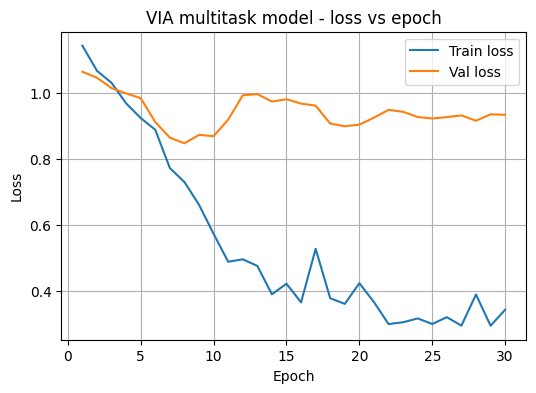

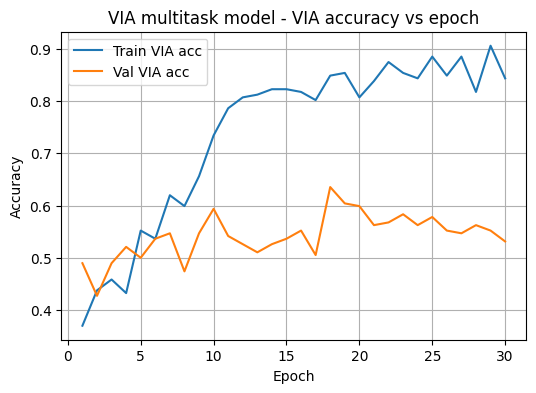

In [ ]:

# ==== Plot training curves: loss & VIA accuracy ====

epochs_range = range(1, len(history["train_loss"]) + 1)

plt.figure(figsize=(6,4))
plt.plot(epochs_range, history["train_loss"], label="Train loss")
plt.plot(epochs_range, history["val_loss"],   label="Val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("VIA multitask model - loss vs epoch")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(6,4))
plt.plot(epochs_range, history["train_via_acc"], label="Train VIA acc")
plt.plot(epochs_range, history["val_via_acc"],   label="Val VIA acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("VIA multitask model - VIA accuracy vs epoch")
plt.legend()
plt.grid(True)
plt.show()


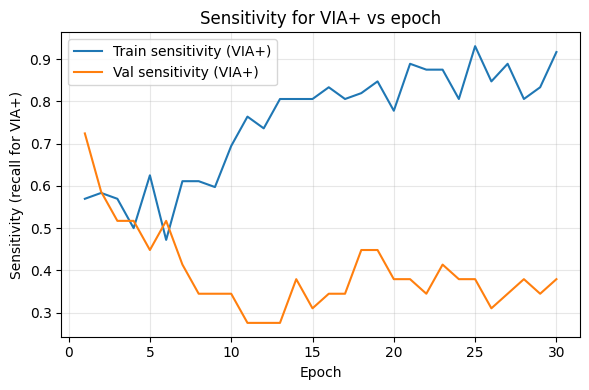

In [ ]:
plt.figure(figsize=(6, 4))
plt.plot(epochs_range, history["train_sensitivity_pos"], label="Train sensitivity (VIA+)")
plt.plot(epochs_range, history["val_sensitivity_pos"],   label="Val sensitivity (VIA+)")
plt.xlabel("Epoch")
plt.ylabel("Sensitivity (recall for VIA+)")
plt.title("Sensitivity for VIA+ vs epoch")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

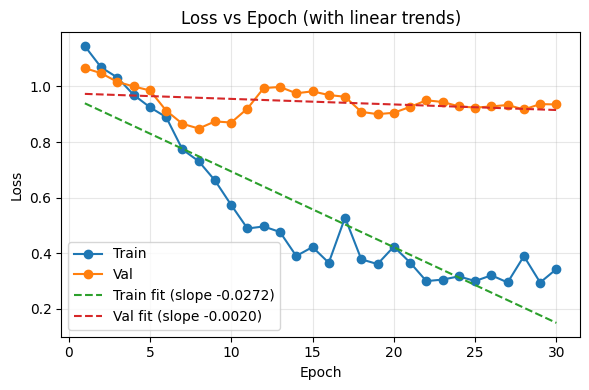

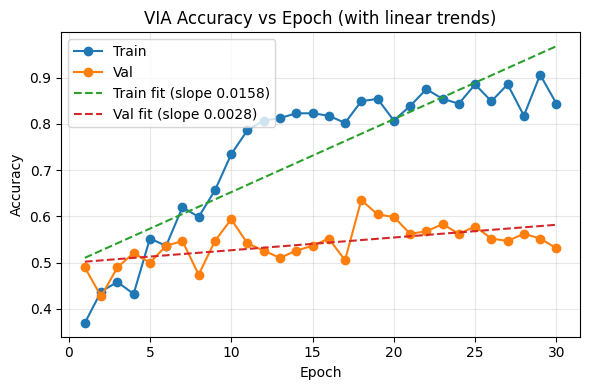

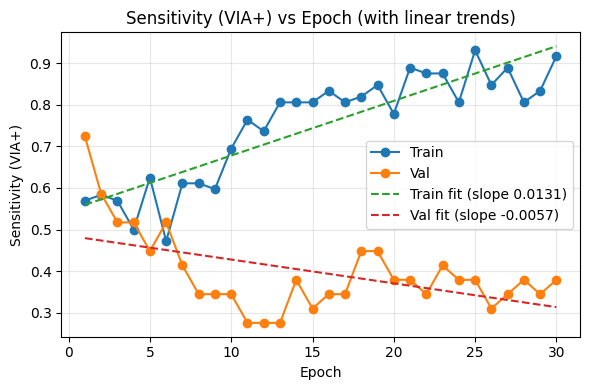

In [ ]:
epochs_range = np.arange(1, len(history["train_loss"]) + 1)

def plot_curve_with_fit(x, y_train, y_val, ylabel, title):
    # Fit simple lines: y = a*x + b
    train_coef = np.polyfit(x, y_train, 1)
    val_coef   = np.polyfit(x, y_val,   1)
    train_fit  = np.polyval(train_coef, x)
    val_fit    = np.polyval(val_coef,   x)

    plt.figure(figsize=(6,4))
    plt.plot(x, y_train, "o-", label="Train")
    plt.plot(x, y_val,   "o-", label="Val")

    # lines of best fit
    plt.plot(x, train_fit, "--", label=f"Train fit (slope {train_coef[0]:.4f})")
    plt.plot(x, val_fit,   "--", label=f"Val fit (slope {val_coef[0]:.4f})")

    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_curve_with_fit(
    epochs_range,
    history["train_loss"],
    history["val_loss"],
    ylabel="Loss",
    title="Loss vs Epoch (with linear trends)"
)

plot_curve_with_fit(
    epochs_range,
    history["train_via_acc"],
    history["val_via_acc"],
    ylabel="Accuracy",
    title="VIA Accuracy vs Epoch (with linear trends)"
)

plot_curve_with_fit(
    epochs_range,
    history["train_sensitivity_pos"],
    history["val_sensitivity_pos"],
    ylabel="Sensitivity (VIA+)",
    title="Sensitivity (VIA+) vs Epoch (with linear trends)"
)


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Confusion matrix (rows=true, cols=pred):
[[26  0  6]
 [ 1  1  1]
 [11  1 13]]

Classification report:
              precision    recall  f1-score   support

           0      0.684     0.812     0.743        32
           1      0.500     0.333     0.400         3
           2      0.650     0.520     0.578        25

    accuracy                          0.667        60
   macro avg      0.611     0.555     0.574        60
weighted avg      0.661     0.667     0.657        60



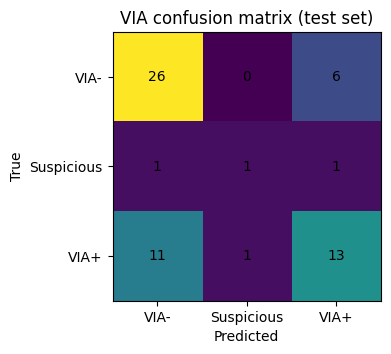

In [ ]:

# ==== Test-set evaluation (VIA head) ====
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix,
    classification_report,
    roc_curve,
    auc,
)
from sklearn.preprocessing import label_binarize

def eval_via_full_metrics(model, loader, device, split_name="Validation", n_bootstrap=200):
    """
    Computes:
      - accuracy
      - precision / recall / F1: per-class, macro, micro
      - bootstrap std for per-class + macro/micro P/R/F1
      - confusion matrix
      - sensitivity for VIA+ (class 2)
      - logits + probabilities (for ROC curves)
    """
    model.eval()
    all_targets = []
    all_preds = []
    all_logits = []

    with torch.no_grad():
        for images, via_targets, attr_targets, meta in loader:
            images = images.to(device)
            via_targets = via_targets.to(device)

            outputs = model(images)
            logits = outputs["via_logits"]

            preds = torch.argmax(logits, dim=1)

            all_targets.append(via_targets.cpu())
            all_preds.append(preds.cpu())
            all_logits.append(logits.cpu())

    if len(all_targets) == 0:
        raise RuntimeError(f"{split_name}: loader is empty.")

    y_true = torch.cat(all_targets).numpy()    # [N]
    y_pred = torch.cat(all_preds).numpy()      # [N]
    logits_all = torch.cat(all_logits).numpy() # [N, 3]

    # Softmax probabilities
    logits_shift = logits_all - logits_all.max(axis=1, keepdims=True)
    exp_logits = np.exp(logits_shift)
    probs = exp_logits / exp_logits.sum(axis=1, keepdims=True)

    labels = [0, 1, 2]
    class_names = ["Negative", "Suspicious", "Positive"]

    # --- Point estimates ---
    acc = accuracy_score(y_true, y_pred)

    prec_per, rec_per, f1_per, support = precision_recall_fscore_support(
        y_true, y_pred, labels=labels, zero_division=0
    )

    prec_macro, rec_macro, f1_macro, _ = precision_recall_fscore_support(
        y_true, y_pred, average="macro", zero_division=0
    )
    prec_micro, rec_micro, f1_micro, _ = precision_recall_fscore_support(
        y_true, y_pred, average="micro", zero_division=0
    )

    cm = confusion_matrix(y_true, y_pred, labels=labels)
    via_pos_idx = 2
    sensitivity_via_pos = rec_per[via_pos_idx]

    # --- Bootstrap stds over samples (not across runs) ---
    rng = np.random.default_rng(2025)
    N = len(y_true)
    boot_prec_per  = []
    boot_rec_per   = []
    boot_f1_per    = []
    boot_prec_macro = []
    boot_prec_micro = []
    boot_rec_macro  = []
    boot_rec_micro  = []
    boot_f1_macro   = []
    boot_f1_micro   = []

    for _ in range(n_bootstrap):
        idx = rng.integers(0, N, size=N)
        yt_b = y_true[idx]
        yp_b = y_pred[idx]

        p_per, r_per, f_per, _ = precision_recall_fscore_support(
            yt_b, yp_b, labels=labels, zero_division=0
        )
        p_mac, r_mac, f_mac, _ = precision_recall_fscore_support(
            yt_b, yp_b, average="macro", zero_division=0
        )
        p_mic, r_mic, f_mic, _ = precision_recall_fscore_support(
            yt_b, yp_b, average="micro", zero_division=0
        )

        boot_prec_per.append(p_per)
        boot_rec_per.append(r_per)
        boot_f1_per.append(f_per)
        boot_prec_macro.append(p_mac)
        boot_prec_micro.append(p_mic)
        boot_rec_macro.append(r_mac)
        boot_rec_micro.append(r_mic)
        boot_f1_macro.append(f_mac)
        boot_f1_micro.append(f_mic)

    boot_prec_per  = np.stack(boot_prec_per, axis=0)   # [B, 3]
    boot_rec_per   = np.stack(boot_rec_per, axis=0)
    boot_f1_per    = np.stack(boot_f1_per, axis=0)

    prec_per_std   = boot_prec_per.std(axis=0)
    rec_per_std    = boot_rec_per.std(axis=0)
    f1_per_std     = boot_f1_per.std(axis=0)

    prec_macro_std = np.std(boot_prec_macro)
    prec_micro_std = np.std(boot_prec_micro)
    rec_macro_std  = np.std(boot_rec_macro)
    rec_micro_std  = np.std(boot_rec_micro)
    f1_macro_std   = np.std(boot_f1_macro)
    f1_micro_std   = np.std(boot_f1_micro)

    # --- Print summary ---
    print(f"\n=== {split_name} Metrics ===")
    print(f"Accuracy: {acc:.3f}")
    print(f"Precision macro: {prec_macro:.3f} ± {prec_macro_std:.3f}, "
          f"micro: {prec_micro:.3f} ± {prec_micro_std:.3f}")
    print(f"Recall    macro: {rec_macro:.3f} ± {rec_macro_std:.3f}, "
          f"micro: {rec_micro:.3f} ± {rec_micro_std:.3f}")
    print(f"F1        macro: {f1_macro:.3f} ± {f1_macro_std:.3f}, "
          f"micro: {f1_micro:.3f} ± {f1_micro_std:.3f}")
    print(f"Sensitivity (VIA+, class 2): {sensitivity_via_pos:.3f}")

    print("\nPer-class (P/R/F1):")
    for i, name in enumerate(class_names):
        print(f"  {i} ({name}): "
              f"P={prec_per[i]:.3f}±{prec_per_std[i]:.3f}, "
              f"R={rec_per[i]:.3f}±{rec_per_std[i]:.3f}, "
              f"F1={f1_per[i]:.3f}±{f1_per_std[i]:.3f}, "
              f"N={support[i]}")

    print("\nConfusion Matrix (rows=true, cols=pred):")
    print(cm)
    print("\nClassification report:")
    print(classification_report(y_true, y_pred, target_names=class_names, digits=3, zero_division=0))

    metrics = {
        "accuracy": acc,
        "prec_per": prec_per,
        "prec_per_std": prec_per_std,
        "prec_macro": prec_macro,
        "prec_macro_std": prec_macro_std,
        "prec_micro": prec_micro,
        "prec_micro_std": prec_micro_std,
        "rec_per": rec_per,
        "rec_per_std": rec_per_std,
        "rec_macro": rec_macro,
        "rec_macro_std": rec_macro_std,
        "rec_micro": rec_micro,
        "rec_micro_std": rec_micro_std,
        "f1_per": f1_per,
        "f1_per_std": f1_per_std,
        "f1_macro": f1_macro,
        "f1_macro_std": f1_macro_std,
        "f1_micro": f1_micro,
        "f1_micro_std": f1_micro_std,
        "support": support,
        "cm": cm,
        "confusion_matrix": cm,
        "sensitivity_via_pos": sensitivity_via_pos,
        "class_names": class_names,
        "y_true": y_true,
        "y_pred": y_pred,
        "logits": logits_all,
        "probs": probs,
    }
    return metrics



model.eval()
all_true = []
all_pred = []

with torch.no_grad():
    for images, via_targets, attr_targets, meta in test_loader:
        images = images.to(device)
        via_targets = via_targets.to(device)
        outputs = model(images)
        preds = outputs["via_logits"].argmax(dim=1)
        all_true.extend(via_targets.cpu().tolist())
        all_pred.extend(preds.cpu().tolist())

cm = confusion_matrix(all_true, all_pred, labels=[0,1,2])
print("Confusion matrix (rows=true, cols=pred):")
print(cm)
print("\nClassification report:")
print(classification_report(all_true, all_pred, digits=3))

fig, ax = plt.subplots(figsize=(4,4))
im = ax.imshow(cm)
ax.set_xticks([0,1,2])
ax.set_yticks([0,1,2])
ax.set_xticklabels(["VIA-", "Suspicious", "VIA+"])
ax.set_yticklabels(["VIA-", "Suspicious", "VIA+"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("VIA confusion matrix (test set)")

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, int(cm[i,j]), ha="center", va="center")

plt.tight_layout()
plt.show()


In [ ]:
val_stats  = eval_via_full_metrics(model, val_loader,  device, split_name="Validation", n_bootstrap=200)
test_stats = eval_via_full_metrics(model, test_loader, device, split_name="Test",        n_bootstrap=200)


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)



=== Validation Metrics ===
Accuracy: 0.550
Precision macro: 0.639 ± 0.076, micro: 0.550 ± 0.060
Recall    macro: 0.601 ± 0.075, micro: 0.550 ± 0.060
F1        macro: 0.601 ± 0.073, micro: 0.550 ± 0.060
Sensitivity (VIA+, class 2): 0.379

Per-class (P/R/F1):
  0 (Negative): P=0.472±0.081, R=0.708±0.093, F1=0.567±0.076, N=24
  1 (Suspicious): P=0.833±0.187, R=0.714±0.193, F1=0.769±0.169, N=7
  2 (Positive): P=0.611±0.110, R=0.379±0.080, F1=0.468±0.082, N=29

Confusion Matrix (rows=true, cols=pred):
[[17  0  7]
 [ 2  5  0]
 [17  1 11]]

Classification report:
              precision    recall  f1-score   support

    Negative      0.472     0.708     0.567        24
  Suspicious      0.833     0.714     0.769         7
    Positive      0.611     0.379     0.468        29

    accuracy                          0.550        60
   macro avg      0.639     0.601     0.601        60
weighted avg      0.581     0.550     0.543        60



/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)



=== Test Metrics ===
Accuracy: 0.667
Precision macro: 0.611 ± 0.138, micro: 0.667 ± 0.057
Recall    macro: 0.555 ± 0.110, micro: 0.667 ± 0.057
F1        macro: 0.574 ± 0.109, micro: 0.667 ± 0.057
Sensitivity (VIA+, class 2): 0.520

Per-class (P/R/F1):
  0 (Negative): P=0.684±0.075, R=0.812±0.065, F1=0.743±0.056, N=32
  1 (Suspicious): P=0.500±0.404, R=0.333±0.319, F1=0.400±0.307, N=3
  2 (Positive): P=0.650±0.105, R=0.520±0.097, F1=0.578±0.085, N=25

Confusion Matrix (rows=true, cols=pred):
[[26  0  6]
 [ 1  1  1]
 [11  1 13]]

Classification report:
              precision    recall  f1-score   support

    Negative      0.684     0.812     0.743        32
  Suspicious      0.500     0.333     0.400         3
    Positive      0.650     0.520     0.578        25

    accuracy                          0.667        60
   macro avg      0.611     0.555     0.574        60
weighted avg      0.661     0.667     0.657        60



In [ ]:
import pandas as pd

def build_summary_tables(val_stats, test_stats):
    # --------- OVERALL METRICS (Validation vs Test) --------- #
    overall_rows = []
    for name, s in [("Validation", val_stats), ("Test", test_stats)]:
        overall_rows.append({
            "Split": name,
            "Accuracy": s["accuracy"],
            "Precision (macro)": s["prec_macro"],
            "Precision (macro) std": s["prec_macro_std"],
            "Precision (micro)": s["prec_micro"],
            "Precision (micro) std": s["prec_micro_std"],
            "Recall (macro)": s["rec_macro"],
            "Recall (macro) std": s["rec_macro_std"],
            "Recall (micro)": s["rec_micro"],
            "Recall (micro) std": s["rec_micro_std"],
            "F1 (macro)": s["f1_macro"],
            "F1 (macro) std": s["f1_macro_std"],
            "F1 (micro)": s["f1_micro"],
            "F1 (micro) std": s["f1_micro_std"],
            "Sensitivity (VIA+)": s["sensitivity_via_pos"],
        })

    overall_df = pd.DataFrame(overall_rows).set_index("Split")

    # --------- PER-CLASS METRICS (Validation vs Test) --------- #
    # class_names: ["Negative", "Suspicious", "Positive"]
    class_names = val_stats["class_names"]
    labels = range(len(class_names))

    per_class_rows = []
    for split_name, s in [("Validation", val_stats), ("Test", test_stats)]:
        for idx in labels:
            per_class_rows.append({
                "Split": split_name,
                "Class idx": idx,
                "Class name": class_names[idx],
                "Support": int(s["support"][idx]),
                "Precision": s["prec_per"][idx],
                "Precision std": s["prec_per_std"][idx],
                "Recall": s["rec_per"][idx],
                "Recall std": s["rec_per_std"][idx],
                "F1": s["f1_per"][idx],
                "F1 std": s["f1_per_std"][idx],
            })

    per_class_df = pd.DataFrame(per_class_rows).set_index(["Split", "Class idx"])

    return overall_df, per_class_df

overall_df, per_class_df = build_summary_tables(val_stats, test_stats)

print("=== Overall Metrics (Validation vs Test) ===")
display(overall_df)

print("\n=== Per-class Metrics (Validation vs Test) ===")
display(per_class_df)


=== Overall Metrics (Validation vs Test) ===


Accuracy  Precision (macro)  Precision (macro) std  \
Split                                                            
Validation  0.550000           0.638889               0.076438   
Test        0.666667           0.611404               0.137602   

            Precision (micro)  Precision (micro) std  Recall (macro)  \
Split                                                                  
Validation           0.550000               0.060198        0.600643   
Test                 0.666667               0.056856        0.555278   

            Recall (macro) std  Recall (micro)  Recall (micro) std  \
Split                                                                
Validation            0.075133        0.550000            0.060198   
Test                  0.109994        0.666667            0.056856   

            F1 (macro)  F1 (macro) std  F1 (micro)  F1 (micro) std  \
Split                                                                
Validation    0.601328        0.072907    0.550000        0.060198   
Test          0.573545        0.109352    0.666667        0.056856   

            Sensitivity (VIA+)  
Split                           
Validation             0.37931  
Test                   0.52000


=== Per-class Metrics (Validation vs Test) ===


Class name  Support  Precision  Precision std    Recall  \
Split      Class idx                                                            
Validation 0            Negative       24   0.472222       0.081221  0.708333   
           1          Suspicious        7   0.833333       0.186591  0.714286   
           2            Positive       29   0.611111       0.109857  0.379310   
Test       0            Negative       32   0.684211       0.074534  0.812500   
           1          Suspicious        3   0.500000       0.404371  0.333333   
           2            Positive       25   0.650000       0.104735  0.520000   

                      Recall std        F1    F1 std  
Split      Class idx                                  
Validation 0            0.093108  0.566667  0.076029  
           1            0.192504  0.769231  0.168814  
           2            0.080155  0.468085  0.082006  
Test       0            0.064889  0.742857  0.055749  
           1            0.319391  0.400000  0.307363  
           2            0.096550  0.577778  0.085413

/tmp/ipython-input-676868012.py:13: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_disp = df_disp.applymap(


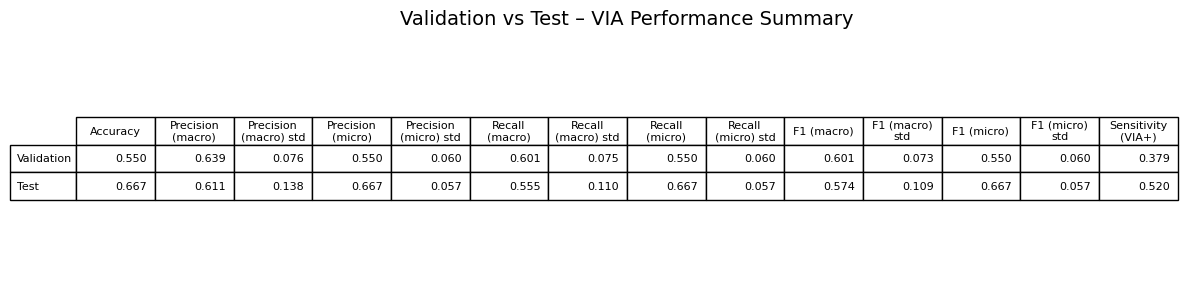

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

import matplotlib.pyplot as plt
import numpy as np
from textwrap import wrap

def plot_overall_table(overall_df, title="Overall VIA Metrics"):
    fig, ax = plt.subplots(figsize=(12, 3))
    ax.axis("off")

    df_disp = overall_df.copy()
    df_disp = df_disp.applymap(
        lambda x: f"{x:.3f}" if isinstance(x, (int, float, np.floating)) else x
    )

    # Apply wrapping
    wrap_len = 12
    col_labels = ["\n".join(wrap(c, wrap_len)) for c in df_disp.columns]

    cell_text = []
    for row in df_disp.values:
        wrapped_row = []
        for cell in row:
            wrapped_row.append("\n".join(wrap(str(cell), wrap_len)))
        cell_text.append(wrapped_row)

    table = ax.table(
        cellText=cell_text,
        colLabels=col_labels,
        rowLabels=df_disp.index,
        loc="center"
    )

    table.auto_set_font_size(False)
    table.set_fontsize(8)
    table.scale(1.2, 1.6)  # widen x and grow row height

    ax.set_title(title, fontsize=14, pad=10)
    plt.tight_layout()
    plt.show()


plot_overall_table(overall_df, title="Validation vs Test – VIA Performance Summary")


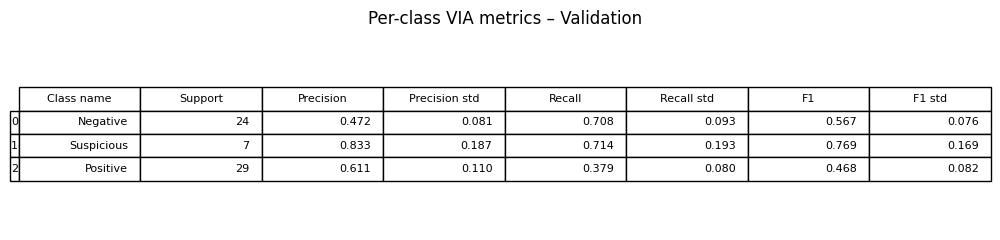

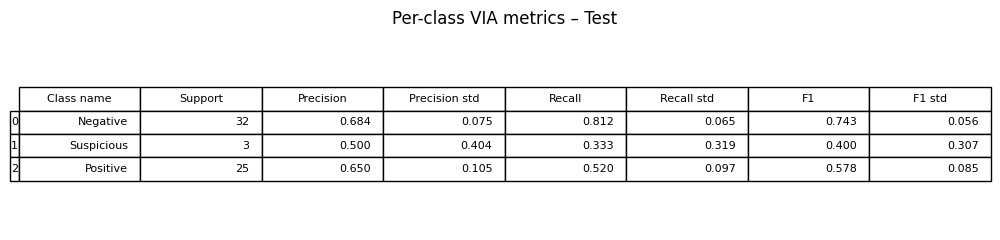

In [ ]:
def plot_per_class_table(per_class_df, split="Validation", title=None):
    # Filter one split
    df_split = per_class_df.loc[split].copy()

    # Select and re-order columns
    df_show = df_split[[
        "Class name",
        "Support",
        "Precision", "Precision std",
        "Recall", "Recall std",
        "F1", "F1 std"
    ]]

    # Round numeric values
    for col in ["Precision", "Precision std", "Recall", "Recall std", "F1", "F1 std"]:
        df_show[col] = df_show[col].apply(lambda x: f"{x:.3f}")

    fig, ax = plt.subplots(figsize=(10, 2.5))
    ax.axis("off")

    table = ax.table(
        cellText=df_show.values,
        colLabels=df_show.columns,
        rowLabels=df_show.index,  # class idx
        loc="center"
    )
    table.auto_set_font_size(False)
    table.set_fontsize(8)
    table.scale(1.1, 1.4)

    if title is None:
        title = f"Per-class VIA metrics – {split}"
    ax.set_title(title, fontsize=12, pad=10)
    plt.tight_layout()
    plt.show()

plot_per_class_table(per_class_df, split="Validation")
plot_per_class_table(per_class_df, split="Test")


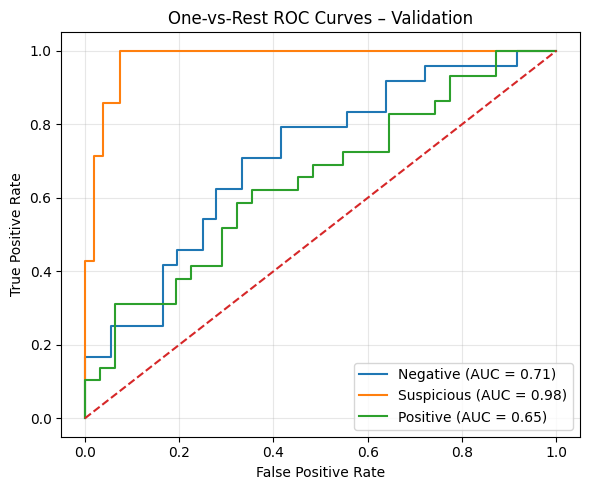

In [ ]:
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

def plot_roc_curves(stats, split_name="Validation"):
    y_true = stats["y_true"]
    probs = stats["probs"]           # [N, 3]
    class_names = stats["class_names"]
    labels = [0, 1, 2]

    # Binarize labels for one-vs-rest ROC
    y_true_bin = label_binarize(y_true, classes=labels)  # [N, 3]

    plt.figure(figsize=(6, 5))
    for idx, name in enumerate(class_names):
        fpr, tpr, _ = roc_curve(y_true_bin[:, idx], probs[:, idx])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")

    # Chance line
    plt.plot([0, 1], [0, 1], linestyle="--")

    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"One-vs-Rest ROC Curves – {split_name}")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Example:
plot_roc_curves(val_stats, "Validation")
# plot_roc_curves(test_stats, "Test")


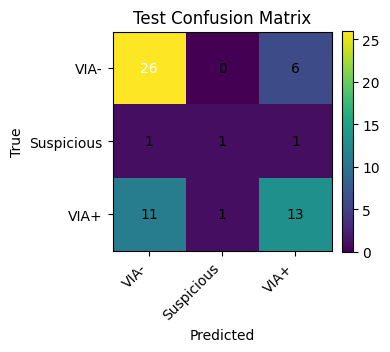

In [ ]:
cm = test_stats["confusion_matrix"]
class_names = ["VIA-", "Suspicious", "VIA+"]

fig, ax = plt.subplots(figsize=(4, 4))
im = ax.imshow(cm, interpolation="nearest")

ax.set_xticks(np.arange(len(class_names)))
ax.set_yticks(np.arange(len(class_names)))
ax.set_xticklabels(class_names, rotation=45, ha="right")
ax.set_yticklabels(class_names)

ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_title("Test Confusion Matrix")

# Write counts in cells
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, int(cm[i, j]),
                ha="center", va="center", color="white" if cm[i, j] > cm.max()/2 else "black")

fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

In [ ]:
def plot_precision(stats, split_name="Validation"):
    class_names = stats["class_names"]
    prec_per    = stats["prec_per"]
    prec_std    = stats["prec_per_std"]
    prec_macro  = stats["prec_macro"]
    prec_micro  = stats["prec_micro"]

    x = np.arange(len(class_names))

    plt.figure(figsize=(8, 5))
    bars = plt.bar(
        x, prec_per,
        yerr=prec_std,
        capsize=5,
        color="skyblue",
        edgecolor="black",
        alpha=0.9,
        label="Per-class precision"
    )
    plt.xticks(x, class_names, rotation=20)
    plt.ylim(0, 1.0)
    plt.ylabel("Precision")
    plt.title(f"{split_name} – Precision per Class (with bootstrap std)")

    for i, bar in enumerate(bars):
        h = bar.get_height()
        plt.text(i, h + 0.04, f"{h:.2f}", ha="center", va="bottom", fontsize=9)

    # macro/micro lines
    plt.axhline(prec_macro, linestyle="--", color="red",  label=f"Macro: {prec_macro:.3f}")
    plt.axhline(prec_micro, linestyle=":",  color="green", label=f"Micro: {prec_micro:.3f}")

    plt.legend()
    plt.grid(axis="y", alpha=0.3)
    plt.tight_layout()
    plt.show()


def plot_recall(stats, split_name="Validation"):
    class_names = stats["class_names"]
    rec_per     = stats["rec_per"]
    rec_std     = stats["rec_per_std"]
    rec_macro   = stats["rec_macro"]
    rec_micro   = stats["rec_micro"]

    x = np.arange(len(class_names))

    plt.figure(figsize=(8, 5))
    bars = plt.bar(
        x, rec_per,
        yerr=rec_std,
        capsize=5,
        color="orange",
        edgecolor="black",
        alpha=0.9,
        label="Per-class recall"
    )
    plt.xticks(x, class_names, rotation=20)
    plt.ylim(0, 1.0)
    plt.ylabel("Recall (Sensitivity)")
    plt.title(f"{split_name} – Recall per Class (with bootstrap std)")

    for i, bar in enumerate(bars):
        h = bar.get_height()
        plt.text(i, h + 0.04, f"{h:.2f}", ha="center", va="bottom", fontsize=9)

    plt.axhline(rec_macro, linestyle="--", color="red",  label=f"Macro: {rec_macro:.3f}")
    plt.axhline(rec_micro, linestyle=":",  color="green", label=f"Micro: {rec_micro:.3f}")

    plt.legend()
    plt.grid(axis="y", alpha=0.3)
    plt.tight_layout()
    plt.show()


def plot_f1(stats, split_name="Validation"):
    class_names = stats["class_names"]
    f1_per      = stats["f1_per"]
    f1_std      = stats["f1_per_std"]
    f1_macro    = stats["f1_macro"]
    f1_micro    = stats["f1_micro"]

    x = np.arange(len(class_names))

    plt.figure(figsize=(8, 5))
    bars = plt.bar(
        x, f1_per,
        yerr=f1_std,
        capsize=5,
        color="darkgreen",
        edgecolor="black",
        alpha=0.9,
        label="Per-class F1"
    )
    plt.xticks(x, class_names, rotation=20)
    plt.ylim(0, 1.0)
    plt.ylabel("F1 score")
    plt.title(f"{split_name} – F1 per Class (with bootstrap std)")

    for i, bar in enumerate(bars):
        h = bar.get_height()
        plt.text(i, h + 0.04, f"{h:.2f}", ha="center", va="bottom", fontsize=9)

    plt.axhline(f1_macro, linestyle="--", color="red",  label=f"Macro: {f1_macro:.3f}")
    plt.axhline(f1_micro, linestyle=":",  color="green", label=f"Micro: {f1_micro:.3f}")

    plt.legend()
    plt.grid(axis="y", alpha=0.3)
    plt.tight_layout()
    plt.show()


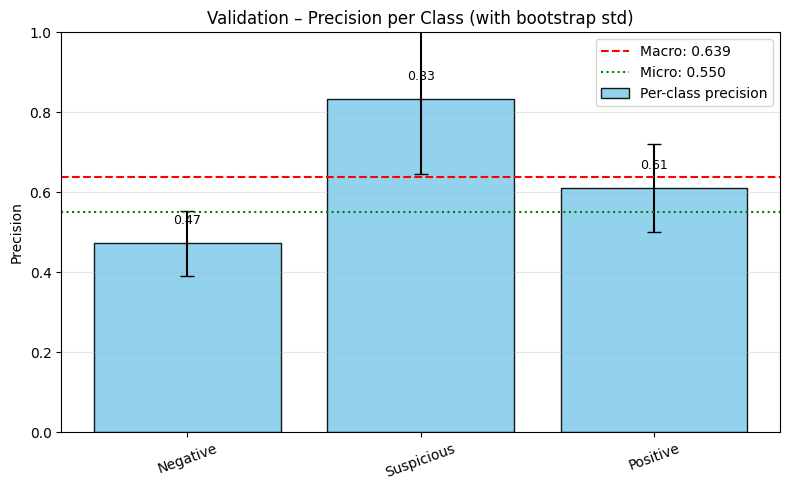

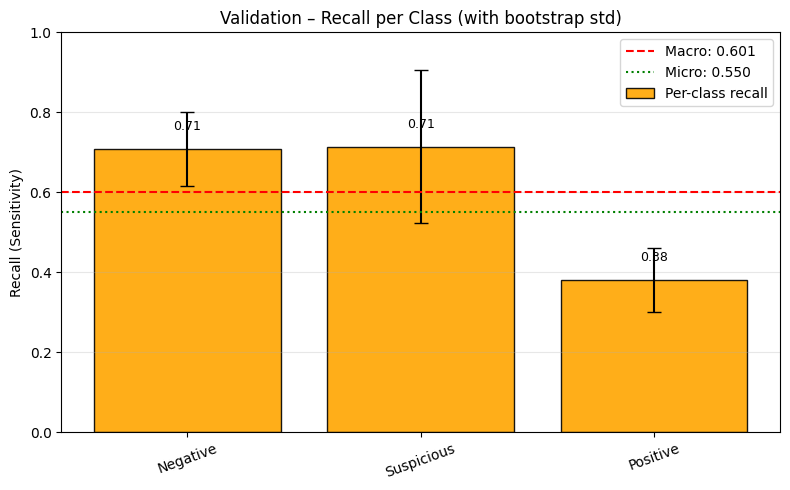

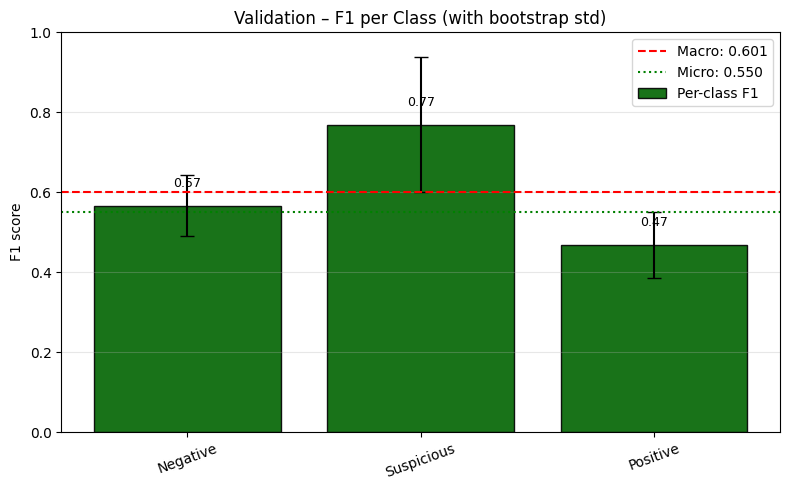

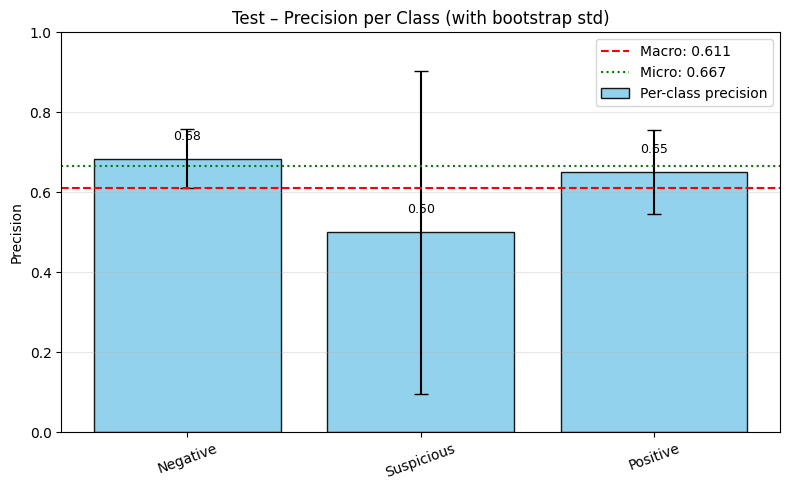

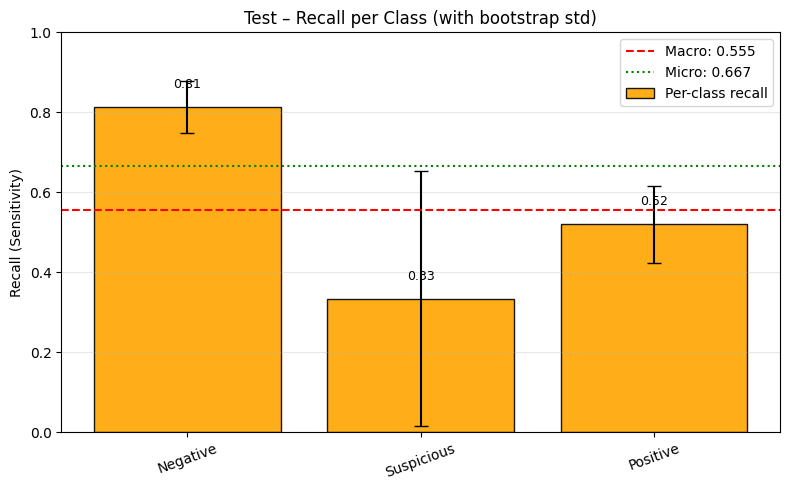

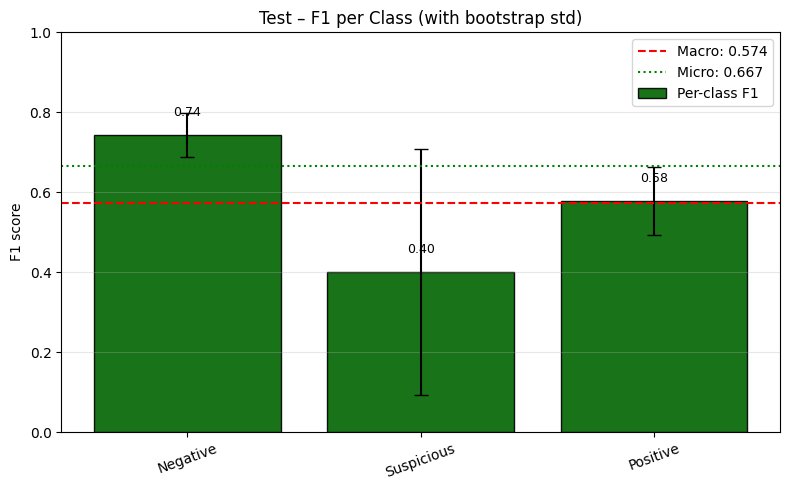

In [ ]:
plot_precision(val_stats, "Validation")
plot_recall(val_stats,    "Validation")
plot_f1(val_stats,        "Validation")

plot_precision(test_stats, "Test")
plot_recall(test_stats,    "Test")
plot_f1(test_stats,        "Test")


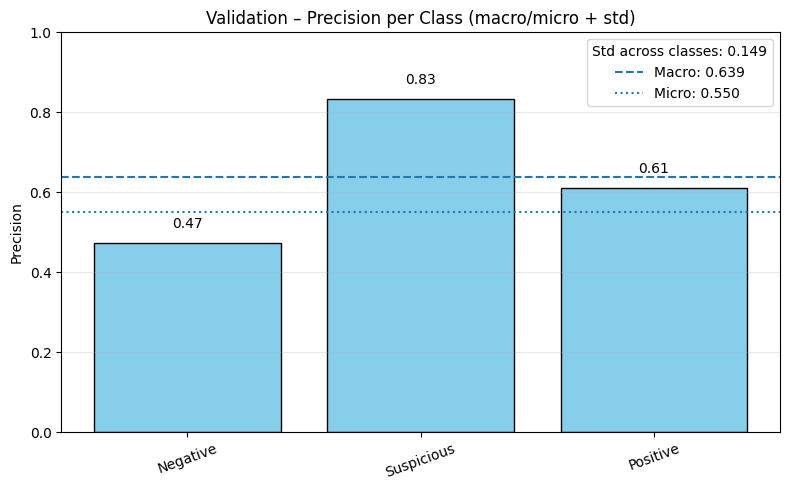

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_precision(stats, split_name="Validation"):
    class_names = stats["class_names"]
    prec_per = stats["prec_per"]       # per class
    prec_macro = stats["prec_macro"]
    prec_micro = stats["prec_micro"]
    prec_std = stats["prec_std"]

    x = np.arange(len(class_names))

    plt.figure(figsize=(8, 5))

    # Per-class bars
    bars = plt.bar(x, prec_per, color="skyblue", edgecolor="black")
    plt.xticks(x, class_names, rotation=20)
    plt.ylim(0, 1.0)
    plt.ylabel("Precision")
    plt.title(f"{split_name} – Precision per Class (macro/micro + std)")

    # Annotate bars with values
    for i, bar in enumerate(bars):
        h = bar.get_height()
        plt.text(i, h + 0.03, f"{h:.2f}", ha="center", va="bottom")

    # Add macro & micro as horizontal lines
    plt.axhline(prec_macro, linestyle="--", label=f"Macro: {prec_macro:.3f}")
    plt.axhline(prec_micro, linestyle=":",  label=f"Micro: {prec_micro:.3f}")

    # Show std across classes in legend text
    plt.legend(title=f"Std across classes: {prec_std:.3f}")
    plt.grid(axis="y", alpha=0.3)
    plt.tight_layout()
    plt.show()

# Example:
plot_precision(val_stats, "Validation")


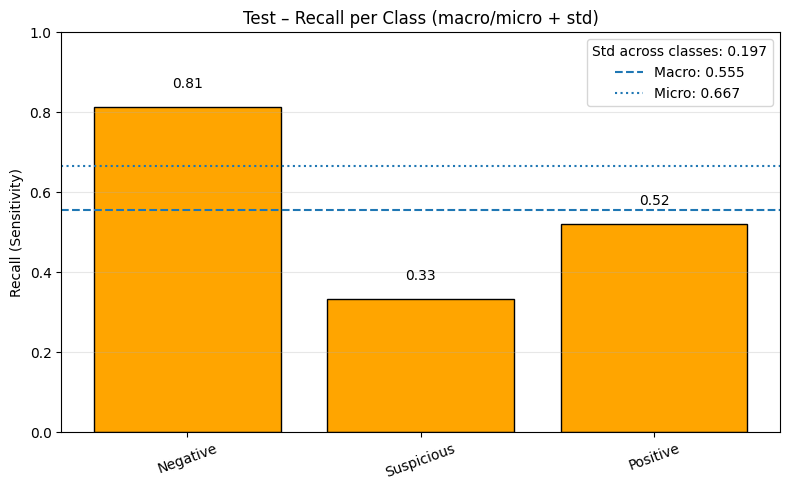

In [ ]:
def plot_recall(stats, split_name="Validation"):
    class_names = stats["class_names"]
    rec_per = stats["rec_per"]
    rec_macro = stats["rec_macro"]
    rec_micro = stats["rec_micro"]
    rec_std = stats["rec_std"]

    x = np.arange(len(class_names))

    plt.figure(figsize=(8, 5))

    bars = plt.bar(x, rec_per, color="orange", edgecolor="black")
    plt.xticks(x, class_names, rotation=20)
    plt.ylim(0, 1.0)
    plt.ylabel("Recall (Sensitivity)")
    plt.title(f"{split_name} – Recall per Class (macro/micro + std)")

    for i, bar in enumerate(bars):
        h = bar.get_height()
        plt.text(i, h + 0.04, f"{h:.2f}", ha="center", va="bottom")

    plt.axhline(rec_macro, linestyle="--", label=f"Macro: {rec_macro:.3f}")
    plt.axhline(rec_micro, linestyle=":",  label=f"Micro: {rec_micro:.3f}")

    plt.legend(title=f"Std across classes: {rec_std:.3f}")
    plt.grid(axis="y", alpha=0.3)
    plt.tight_layout()
    plt.show()

# Example:
plot_recall(test_stats, "Test")


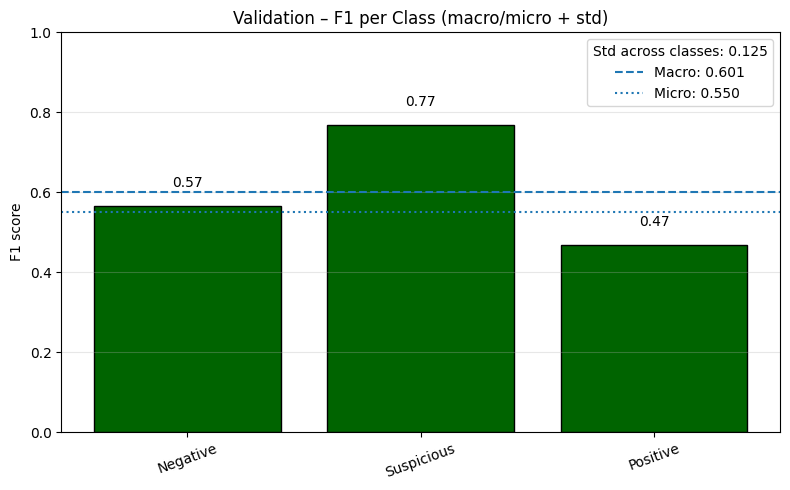

In [ ]:
def plot_f1(stats, split_name="Validation"):
    class_names = stats["class_names"]
    f1_per = stats["f1_per"]
    f1_macro = stats["f1_macro"]
    f1_micro = stats["f1_micro"]
    f1_std = stats["f1_std"]

    x = np.arange(len(class_names))

    plt.figure(figsize=(8, 5))

    bars = plt.bar(x, f1_per, color="darkgreen", edgecolor="black")
    plt.xticks(x, class_names, rotation=20)
    plt.ylim(0, 1.0)
    plt.ylabel("F1 score")
    plt.title(f"{split_name} – F1 per Class (macro/micro + std)")

    for i, bar in enumerate(bars):
        h = bar.get_height()
        plt.text(i, h + 0.04, f"{h:.2f}", ha="center", va="bottom")

    plt.axhline(f1_macro, linestyle="--", label=f"Macro: {f1_macro:.3f}")
    plt.axhline(f1_micro, linestyle=":",  label=f"Micro: {f1_micro:.3f}")

    plt.legend(title=f"Std across classes: {f1_std:.3f}")
    plt.grid(axis="y", alpha=0.3)
    plt.tight_layout()
    plt.show()

# Example:
plot_f1(val_stats, "Validation")


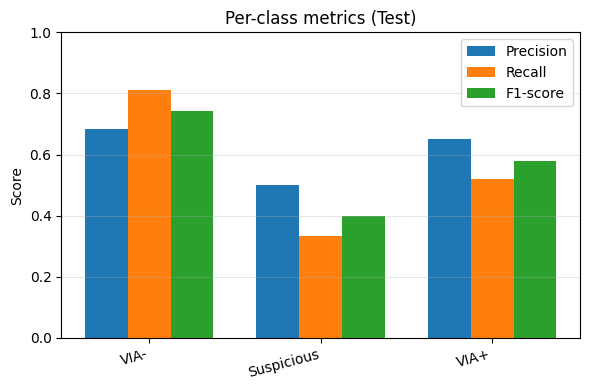

In [ ]:
prec = test_stats["prec_per"]
rec  = test_stats["rec_per"]
f1   = test_stats["f1_per"]

x = np.arange(len(class_names))
width = 0.25

fig, ax = plt.subplots(figsize=(6, 4))
ax.bar(x - width, prec, width, label="Precision")
ax.bar(x,         rec,  width, label="Recall")
ax.bar(x + width, f1,   width, label="F1-score")

ax.set_xticks(x)
ax.set_xticklabels(class_names, rotation=15, ha="right")
ax.set_ylim(0, 1.0)
ax.set_ylabel("Score")
ax.set_title("Per-class metrics (Test)")
ax.legend()
ax.grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.show()


In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

# For denormalizing images for visualization
IMAGENET_MEAN = np.array([0.485, 0.456, 0.406])
IMAGENET_STD  = np.array([0.229, 0.224, 0.225])

def denormalize_img(tensor_img):
    """
    tensor_img: 3 x H x W (normalized)
    returns: H x W x 3 uint8
    """
    img = tensor_img.detach().cpu().numpy()
    img = img.transpose(1, 2, 0)  # CHW -> HWC
    img = IMAGENET_STD * img + IMAGENET_MEAN
    img = np.clip(img, 0, 1)
    img = (img * 255).astype(np.uint8)
    return img

class GradCAM:
    def __init__(self, model, target_module):
        """
        model: your MultiTaskEfficientNet
        target_module: the conv block to hook (e.g. model.trunk.blocks[-1])
        """
        self.model = model
        self.target_module = target_module
        self.gradients = None
        self.activations = None

        self._fwd_hook = target_module.register_forward_hook(self._forward_hook)
        self._bwd_hook = target_module.register_full_backward_hook(self._backward_hook)

    def _forward_hook(self, module, inp, out):
        # out: B x C x H x W
        self.activations = out.detach()

    def _backward_hook(self, module, grad_input, grad_output):
        # grad_output[0]: B x C x H x W
        self.gradients = grad_output[0].detach()

    def generate(self, images, target_class=None):
        """
        images: Tensor B x 3 x H x W (normalized)
        target_class: int or None (if None -> argmax VIA class)
        returns: list of (cam: H x W float32 in [0,1], predicted_class:int)
        """
        self.model.eval()
        images = images.to(device)

        self.model.zero_grad()
        with torch.enable_grad():
            outputs = self.model(images)
            logits = outputs["via_logits"]  # B x num_classes

            if target_class is None:
                target = logits.argmax(dim=1)
            else:
                target = torch.full((logits.size(0),), target_class,
                                    device=logits.device, dtype=torch.long)

            # Gather the logit of the target class for each sample
            selected = logits.gather(1, target.view(-1, 1)).squeeze()

            # Backward on the sum of selected logits
            selected.sum().backward()

        # activations: B x C x H x W
        # gradients:   B x C x H x W
        acts = self.activations   # B x C x H x W
        grads = self.gradients    # B x C x H x W

        cams = []
        preds = target.detach().cpu().tolist()

        for i in range(acts.size(0)):
            A = acts[i]   # C x H x W
            G = grads[i]  # C x H x W

            # Global average pooling over spatial dims -> weights per channel
            weights = G.mean(dim=(1, 2))  # C

            cam = torch.zeros(A.shape[1:], dtype=torch.float32, device=A.device)
            for c, w in enumerate(weights):
                cam += w * A[c]

            cam = F.relu(cam)
            cam = cam - cam.min()
            if cam.max() > 0:
                cam = cam / cam.max()

            cam_np = cam.detach().cpu().numpy()
            cams.append(cam_np)

        return cams, preds


In [ ]:
def overlay_cam_on_image(img_uint8, cam, alpha=0.4, cmap='jet'):
    """
    img_uint8: H x W x 3 uint8 image (denormalized)
    cam: H_cam x W_cam float32 in [0,1]
    returns: H x W x 3 uint8 overlay
    """
    h, w, _ = img_uint8.shape

    # Resize cam to image size
    cam_resized = F.interpolate(
        torch.from_numpy(cam)[None, None, ...].float(),
        size=(h, w),
        mode='bilinear',
        align_corners=False
    )[0, 0].numpy()

    cam_resized = np.clip(cam_resized, 0, 1)

    # Apply colormap
    import matplotlib.cm as cm
    colormap = cm.get_cmap(cmap)
    heatmap = colormap(cam_resized)[..., :3]  # drop alpha
    heatmap = (heatmap * 255).astype(np.uint8)

    overlay = (1 - alpha) * img_uint8.astype(np.float32) + alpha * heatmap.astype(np.float32)
    overlay = np.clip(overlay, 0, 255).astype(np.uint8)
    return overlay


/tmp/ipython-input-1122907790.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap(cmap)


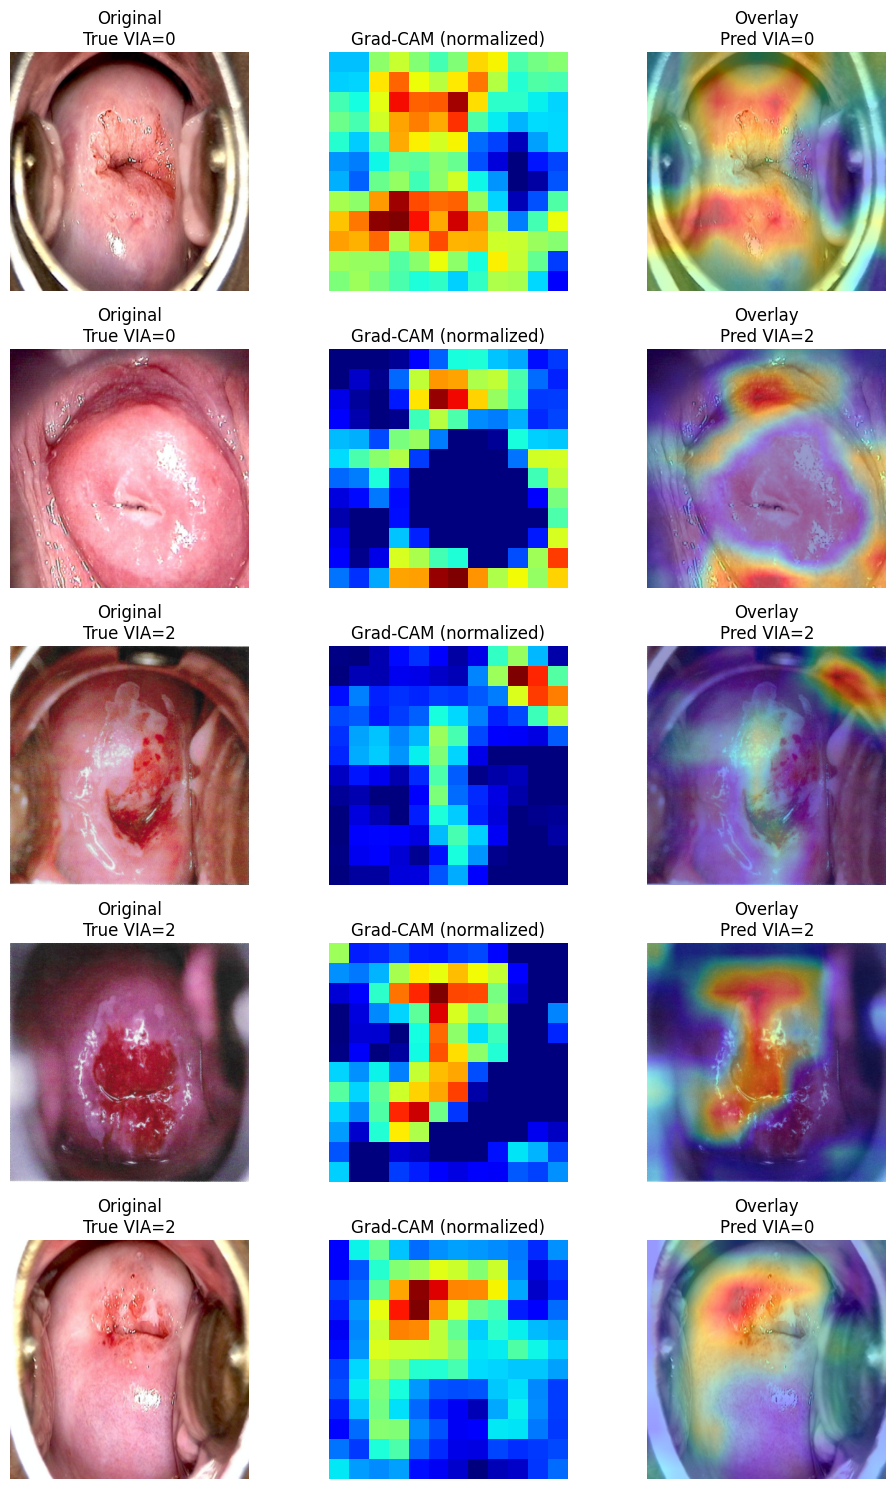

In [ ]:
# === Build Grad-CAM object on the last trunk block ===
target_layer = model.trunk.blocks[-1]  # last EfficientNet block
cam_extractor = GradCAM(model, target_layer)

# Pick a few samples from the validation set
n_samples = 5
indices = np.random.choice(len(val_ds), size=min(n_samples, len(val_ds)), replace=False)

model.eval()
fig, axes = plt.subplots(len(indices), 3, figsize=(10, 3 * len(indices)))

if len(indices) == 1:
    axes = np.expand_dims(axes, axis=0)  # ensure 2D

for row_idx, idx in enumerate(indices):
    img_t, via_label, attr_t, meta = val_ds[idx]  # img_t is normalized tensor
    img_batch = img_t.unsqueeze(0)  # 1 x 3 x H x W

    # Generate CAM
    cams, preds = cam_extractor.generate(img_batch, target_class=None)
    cam = cams[0]
    pred_cls = preds[0]

    # Denormalize image
    img_uint8 = denormalize_img(img_t)

    # Overlay CAM
    overlay = overlay_cam_on_image(img_uint8, cam, alpha=0.4, cmap='jet')

    # Plot: original, heatmap alone, overlay
    ax0, ax1, ax2 = axes[row_idx]

    ax0.imshow(img_uint8)
    ax0.set_title(f"Original\nTrue VIA={via_label.item()}")
    ax0.axis("off")

    ax1.imshow(cam, cmap='jet')
    ax1.set_title("Grad-CAM (normalized)")
    ax1.axis("off")

    ax2.imshow(overlay)
    ax2.set_title(f"Overlay\nPred VIA={pred_cls}")
    ax2.axis("off")

plt.tight_layout()
plt.show()


In [ ]:
EXTERNAL_ROOT = "/content/drive/MyDrive/IARCImageBankVIA/JH"


In [ ]:
import os, glob
from torch.utils.data import Dataset, DataLoader
from PIL import Image

# Reuse your eval transforms
# eval_transforms should already be defined as in your val_ds/test_ds
# If not, recreate the same one you used for validation.
print(eval_transforms)

valid_ext = (".jpg", ".jpeg", ".png", ".tif", ".tiff", ".bmp")

def list_image_files(root):
    files = []
    for ext in valid_ext:
        files.extend(glob.glob(os.path.join(root, "**", f"*{ext}"), recursive=True))
    return sorted(files)

class ExternalImageDataset(Dataset):
    """
    Minimal dataset for arbitrary external images.
    Returns: image_tensor, filepath
    """
    def __init__(self, filepaths, transform=None):
        self.filepaths = filepaths
        self.transform = transform

    def __len__(self):
        return len(self.filepaths)

    def __getitem__(self, idx):
        path = self.filepaths[idx]
        img = Image.open(path).convert("RGB")
        if self.transform is not None:
            img = self.transform(img)
        return img, path

ext_files = list_image_files(EXTERNAL_ROOT)
print(f"Found {len(ext_files)} external images")

external_ds = ExternalImageDataset(ext_files, transform=eval_transforms)
external_loader = DataLoader(
    external_ds,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=False,
    pin_memory=True,
)


Compose(
    Resize(size=(384, 384), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
Found 115 external images


In [ ]:
import torch
import torch.nn.functional as F

# Map class indices to human-readable labels (adjust if your mapping differs)
via_idx_to_label = {
    0: "VIA_negative",
    1: "VIA_suspicious",
    2: "VIA_positive",
}

model.eval()
all_results = []

with torch.no_grad():
    for imgs, paths in external_loader:
        imgs = imgs.to(device)
        outputs = model(imgs)
        logits = outputs["via_logits"]          # B x num_classes
        probs = F.softmax(logits, dim=1)        # B x num_classes
        preds = probs.argmax(dim=1)             # B

        for i in range(imgs.size(0)):
            path = paths[i]
            pred_idx = preds[i].item()
            pred_label = via_idx_to_label.get(pred_idx, f"class_{pred_idx}")
            prob_vec = probs[i].cpu().numpy()

            all_results.append({
                "path": path,
                "pred_idx": pred_idx,
                "pred_label": pred_label,
                "probabilities": prob_vec,
            })

print(f"Ran inference on {len(all_results)} external images")


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Ran inference on 115 external images


In [ ]:
def eval_with_sensitivity(model, loader, pos_class=2):
    model.eval()
    torch.set_grad_enabled(False)

    total_loss = 0.0
    total_acc = 0.0
    n_batches = 0
    tp_total = 0
    fn_total = 0

    for images, labels, *_ in loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        logits = outputs["via_logits"]
        loss = ce_loss(logits, labels)

        preds = logits.argmax(dim=1)
        acc = via_accuracy(logits, labels)

        pos_mask = (labels == pos_class)
        tp_total += ((preds == pos_class) & pos_mask).sum().item()
        fn_total += ((preds != pos_class) & pos_mask).sum().item()

        total_loss += loss.item()
        total_acc += acc
        n_batches += 1

    avg_loss = total_loss / max(1, n_batches)
    avg_acc  = total_acc / max(1, n_batches)
    sens = tp_total / (tp_total + fn_total) if (tp_total + fn_total) > 0 else float("nan")

    return avg_loss, avg_acc, sens


In [ ]:
test_loss, test_acc, test_sens = eval_with_sensitivity(model, test_loader, pos_class=2)
print(f"Test: loss={test_loss:.4f}, acc={test_acc:.4f}, sens_pos={test_sens:.4f}")


Test: loss=0.8617, acc=0.6771, sens_pos=0.5200


In [ ]:
for r in all_results[:10]:
    print(r["path"])
    print("  Pred:", r["pred_label"], "| probs:", r["probabilities"])


/content/drive/MyDrive/IARCImageBankVIA/JH/JHAA1.jpg
  Pred: VIA_positive | probs: [0.44599223 0.0732789  0.4807288 ]
/content/drive/MyDrive/IARCImageBankVIA/JH/JHAB1.jpg
  Pred: VIA_positive | probs: [0.0515392  0.01721707 0.9312437 ]
/content/drive/MyDrive/IARCImageBankVIA/JH/JHAC1.jpg
  Pred: VIA_negative | probs: [0.57885855 0.17872243 0.24241905]
/content/drive/MyDrive/IARCImageBankVIA/JH/JHAD1.jpg
  Pred: VIA_negative | probs: [0.7774568  0.04478534 0.17775786]
/content/drive/MyDrive/IARCImageBankVIA/JH/JHAE1.jpg
  Pred: VIA_negative | probs: [0.38438374 0.35065094 0.26496527]
/content/drive/MyDrive/IARCImageBankVIA/JH/JHAF1.jpg
  Pred: VIA_negative | probs: [0.6284847  0.06107738 0.3104379 ]
/content/drive/MyDrive/IARCImageBankVIA/JH/JHAG1.jpg
  Pred: VIA_suspicious | probs: [0.00479008 0.9850521  0.01015779]
/content/drive/MyDrive/IARCImageBankVIA/JH/JHAH1.jpg
  Pred: VIA_positive | probs: [0.21323517 0.16526093 0.6215039 ]
/content/drive/MyDrive/IARCImageBankVIA/JH/JHAI1.jpg
 

/tmp/ipython-input-1122907790.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap(cmap)


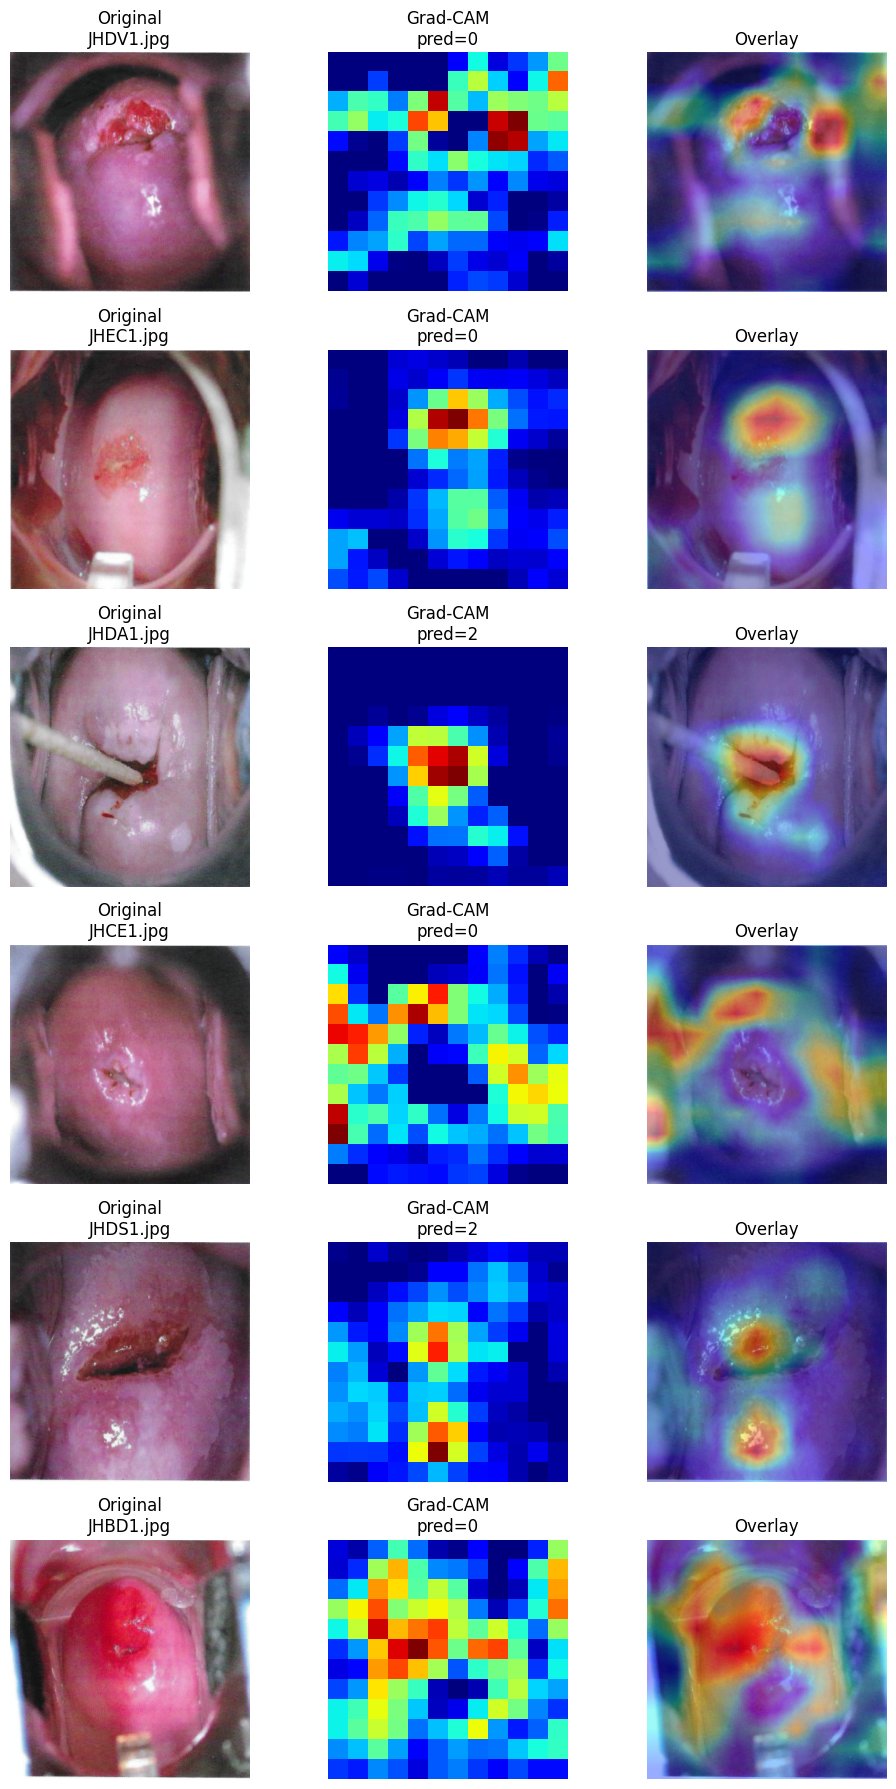

In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt

target_layer = model.trunk.blocks[-1]  # last EfficientNet block
cam_extractor = GradCAM(model, target_layer)

# How many external images to visualize
n_samples = min(6, len(external_ds))
indices = np.random.choice(len(external_ds), size=n_samples, replace=False)

model.eval()
fig, axes = plt.subplots(n_samples, 3, figsize=(10, 3 * n_samples))
if n_samples == 1:
    axes = np.expand_dims(axes, axis=0)  # ensure 2D indexing

for row_idx, idx in enumerate(indices):
    # external_ds returns: img_tensor, path
    img_t, path = external_ds[idx]      # img_t: 3xHxW normalized
    img_batch = img_t.unsqueeze(0)      # 1 x 3 x H x W

    # Run Grad-CAM (for predicted VIA class)
    cams, preds = cam_extractor.generate(img_batch, target_class=None)
    cam = cams[0]
    pred_cls = preds[0]

    # Denormalize image to uint8 for display
    img_uint8 = denormalize_img(img_t)

    # Build overlay
    overlay = overlay_cam_on_image(img_uint8, cam, alpha=0.4, cmap='jet')

    ax0, ax1, ax2 = axes[row_idx]

    ax0.imshow(img_uint8)
    ax0.set_title(f"Original\n{os.path.basename(path)}")
    ax0.axis("off")

    ax1.imshow(cam, cmap='jet')
    ax1.set_title(f"Grad-CAM\npred={pred_cls}")
    ax1.axis("off")

    ax2.imshow(overlay)
    ax2.set_title("Overlay")
    ax2.axis("off")

plt.tight_layout()
plt.show()
